In [1]:
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]      
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]    
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease    
Fetched 257 kB in 1s (347 kB/s)    
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pytho

In [2]:
import os
import tensorflow as tf
import keras

# Print versions and system information
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"CUDA available: {tf.test.is_built_with_cuda()}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

# GPU memory configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Reduce TensorFlow logging verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set global precision policy
tf.keras.mixed_precision.set_global_policy('float32')

# Uncomment to set seed for reproducibility
#tf.random.set_seed(42)

2024-12-08 14:47:22.527266: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 14:47:22.527310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 14:47:22.527375: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 14:47:22.536734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras version: 2.14.0
TensorFlow version: 2.14.0
TensorFlow version: 2.14.0
CUDA available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-12-08 14:47:25.041282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:81:00.0, compute capability: 8.9


In [3]:
from datetime import datetime
import os
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa
import joblib
import re

# Set random state value (None for non-deterministic behavior)
random_state_value = None

# Create execution timestamp for model versioning and logging
execute_name = datetime.now().strftime("%Y-%m-%d_%H-%M")

# Define directory paths
base_project_dir = './'
data_dir = '../../sources/'
models_project_dir = base_project_dir

# Create required directories if they don't exist
os.makedirs(base_project_dir, exist_ok=True)
os.makedirs(models_project_dir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
def clean_column_name(name: str) -> str:
    """
    Cleans column names by removing special characters and converting to snake_case with abbreviations.

    Parameters
    ----------
    name : str
        Column name to clean

    Returns
    -------
    str
        Cleaned column name
    """
    # Remove special characters
    name = re.sub(r'[^a-zA-Z0-9\s]', '', name)

    # Convert to snake_case
    name = name.lower().replace(' ', '_')

    # Common abbreviations mapping
    abbreviations = {
        'production': 'prod',
        'percentage': 'pct',
        'hectare': 'ha',
        'tonnes': 't',
        'litres': 'l',
        'minimum': 'min',
        'maximum': 'max',
        'average': 'avg'
    }

    for full, abbr in abbreviations.items():
        name = name.replace(full, abbr)

    return name


def clean_column_names(df: pd.DataFrame) -> List[str]:
    """
    Cleans all column names in a DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame whose columns need cleaning

    Returns
    -------
    list
        List of cleaned column names
    """
    new_columns = []

    for col in df.columns:
        # Extract variety patterns using regex
        varieties = re.findall(r'([a-z]+)_([a-z_]+)', col)
        if varieties:
            new_columns.append(f"{varieties[0][0]}_{varieties[0][1]}")
        else:
            new_columns.append(col)

    return new_columns

In [5]:
def save_plot(plt, title, output_dir=f'{base_project_dir}/{execute_name}_plots'):
    os.makedirs(output_dir, exist_ok=True)
    filename = "".join(x for x in title if x.isalnum() or x in [' ', '-', '_']).rstrip()
    filename = filename.replace(' ', '_').lower()
    filepath = os.path.join(output_dir, f"{filename}.png")
    plt.savefig(filepath, bbox_inches='tight', dpi=300)
    print(f"Plot salvato come: {filepath}")


def encode_techniques(df, mapping_path=f'{data_dir}technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}. Run create_technique_mapping first.")

    technique_mapping = joblib.load(mapping_path)

    tech_columns = [col for col in df.columns if col.endswith('_tech')]

    # Mapping apply to all tech columns
    for col in tech_columns:
        df[col] = df[col].str.lower().map(technique_mapping).fillna(0).astype(int)

    return df


def decode_single_technique(technique_value, mapping_path=f'{data_dir}technique_mapping.joblib'):
    if not os.path.exists(mapping_path):
        raise FileNotFoundError(f"Mapping not found at {mapping_path}")

    technique_mapping = joblib.load(mapping_path)
    reverse_mapping = {v: k for k, v in technique_mapping.items()}
    reverse_mapping[0] = ''

    return reverse_mapping.get(technique_value, '')


def prepare_comparison_data(simulated_data, olive_varieties):

    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)

    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]
    comparison_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]  # Esclude le righe dove la tecnica è 0

            if not variety_data.empty:
                avg_olive_prod = pd.to_numeric(variety_data[olive_prod_col], errors='coerce').mean()
                avg_oil_prod = pd.to_numeric(variety_data[oil_prod_col], errors='coerce').mean()
                avg_water_need = pd.to_numeric(variety_data[water_need_col], errors='coerce').mean()
                efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                comparison_data.append({
                    'Variety': variety,
                    'Avg Olive Production (kg/ha)': avg_olive_prod,
                    'Avg Oil Production (L/ha)': avg_oil_prod,
                    'Avg Water Need (m³/ha)': avg_water_need,
                    'Oil Efficiency (L/kg)': efficiency,
                    'Water Efficiency (L oil/m³ water)': water_efficiency
                })

    return pd.DataFrame(comparison_data)


def plot_variety_comparison(comparison_data, metric):
    plt.figure(figsize=(12, 6))
    bars = plt.bar(comparison_data['Variety'], comparison_data[metric])
    plt.title(f'Comparison of {metric} across Olive Varieties')
    plt.xlabel('Variety')
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    save_plot(plt, f'variety_comparison_{metric.lower().replace(" ", "_").replace("/", "_").replace("(", "").replace(")", "")}')
    plt.close()


def plot_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Oil Efficiency (L/kg)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Oil Efficiency (L/kg)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Oil Efficiency (L oil / kg olives)')
    plt.tight_layout()
    save_plot(plt, 'efficiency_vs_production')
    plt.close()


def plot_water_efficiency_vs_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Olive Production (kg/ha)'],
                comparison_data['Water Efficiency (L oil/m³ water)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Olive Production (kg/ha)'], row['Water Efficiency (L oil/m³ water)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Water Efficiency vs Olive Production by Variety')
    plt.xlabel('Average Olive Production (kg/ha)')
    plt.ylabel('Water Efficiency (L oil / m³ water)')
    plt.tight_layout()
    plt.show()
    save_plot(plt, 'water_efficiency_vs_production')
    plt.close()


def plot_water_need_vs_oil_production(comparison_data):
    plt.figure(figsize=(10, 6))

    plt.scatter(comparison_data['Avg Water Need (m³/ha)'],
                comparison_data['Avg Oil Production (L/ha)'],
                s=100)

    for i, row in comparison_data.iterrows():
        plt.annotate(row['Variety'],
                     (row['Avg Water Need (m³/ha)'], row['Avg Oil Production (L/ha)']),
                     xytext=(5, 5), textcoords='offset points')

    plt.title('Oil Production vs Water Need by Variety')
    plt.xlabel('Average Water Need (m³/ha)')
    plt.ylabel('Average Oil Production (L/ha)')
    plt.tight_layout()
    plt.show()
    save_plot(plt, 'water_need_vs_oil_production')
    plt.close()


def analyze_by_technique(simulated_data, olive_varieties):

    df = simulated_data.copy()

    df.columns = clean_column_names(df)
    df = encode_techniques(df)
    all_varieties = olive_varieties['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]

    technique_data = []

    for variety in varieties:
        olive_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_olive_prod')), None)
        oil_prod_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_avg_oil_prod')), None)
        tech_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_tech')), None)
        water_need_col = next((col for col in df.columns if col.startswith(f'{variety}_') and col.endswith('_water_need')), None)

        if olive_prod_col and oil_prod_col and tech_col and water_need_col:
            variety_data = df[[olive_prod_col, oil_prod_col, tech_col, water_need_col]]
            variety_data = variety_data[variety_data[tech_col] != 0]

            if not variety_data.empty:
                for tech in variety_data[tech_col].unique():
                    tech_data = variety_data[variety_data[tech_col] == tech]

                    avg_olive_prod = pd.to_numeric(tech_data[olive_prod_col], errors='coerce').mean()
                    avg_oil_prod = pd.to_numeric(tech_data[oil_prod_col], errors='coerce').mean()
                    avg_water_need = pd.to_numeric(tech_data[water_need_col], errors='coerce').mean()

                    efficiency = avg_oil_prod / avg_olive_prod if avg_olive_prod > 0 else 0
                    water_efficiency = avg_oil_prod / avg_water_need if avg_water_need > 0 else 0

                    technique_data.append({
                        'Variety': variety,
                        'Technique': tech,
                        'Technique String': decode_single_technique(tech),
                        'Avg Olive Production (kg/ha)': avg_olive_prod,
                        'Avg Oil Production (L/ha)': avg_oil_prod,
                        'Avg Water Need (m³/ha)': avg_water_need,
                        'Oil Efficiency (L/kg)': efficiency,
                        'Water Efficiency (L oil/m³ water)': water_efficiency
                    })

    return pd.DataFrame(technique_data)

In [6]:
def calculate_real_error(model, test_data, test_targets, scaler_y):

    predictions = model.predict(test_data)

    # Denormalize predictions and target values
    predictions_real = scaler_y.inverse_transform(predictions)
    targets_real = scaler_y.inverse_transform(test_targets)

    # Calculate percentage error for each target
    percentage_errors = []
    absolute_errors = []

    for i in range(predictions_real.shape[1]):
        mae = np.mean(np.abs(predictions_real[:, i] - targets_real[:, i]))
        mape = np.mean(np.abs((predictions_real[:, i] - targets_real[:, i]) / targets_real[:, i])) * 100
        percentage_errors.append(mape)
        absolute_errors.append(mae)

    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 'avg_oil_prod', 'total_water_need']

    print("\nErrori per target:")
    print("-" * 50)
    for i, target in enumerate(target_names):
        print(f"{target}:")
        print(f"MAE assoluto: {absolute_errors[i]:.2f}")
        print(f"Errore percentuale medio: {percentage_errors[i]:.2f}%")
        print(f"Precisione: {100 - percentage_errors[i]:.2f}%")
        print("-" * 50)

    return percentage_errors, absolute_errors

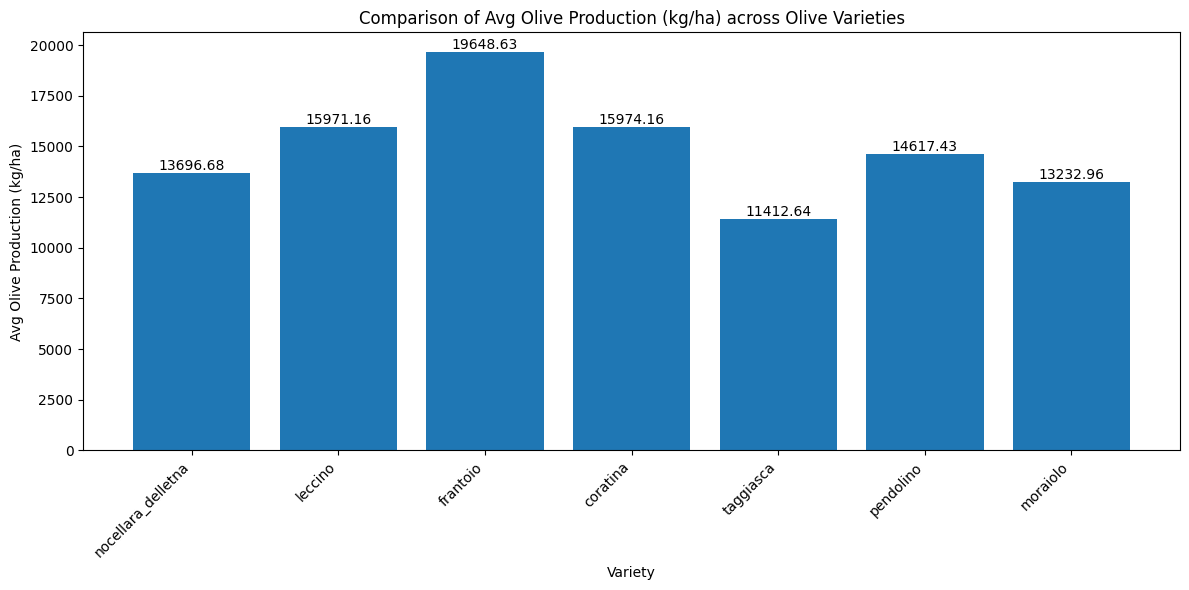

Plot salvato come: .//2024-12-08_14-47_plots/variety_comparison_avg_olive_production_kg_ha.png


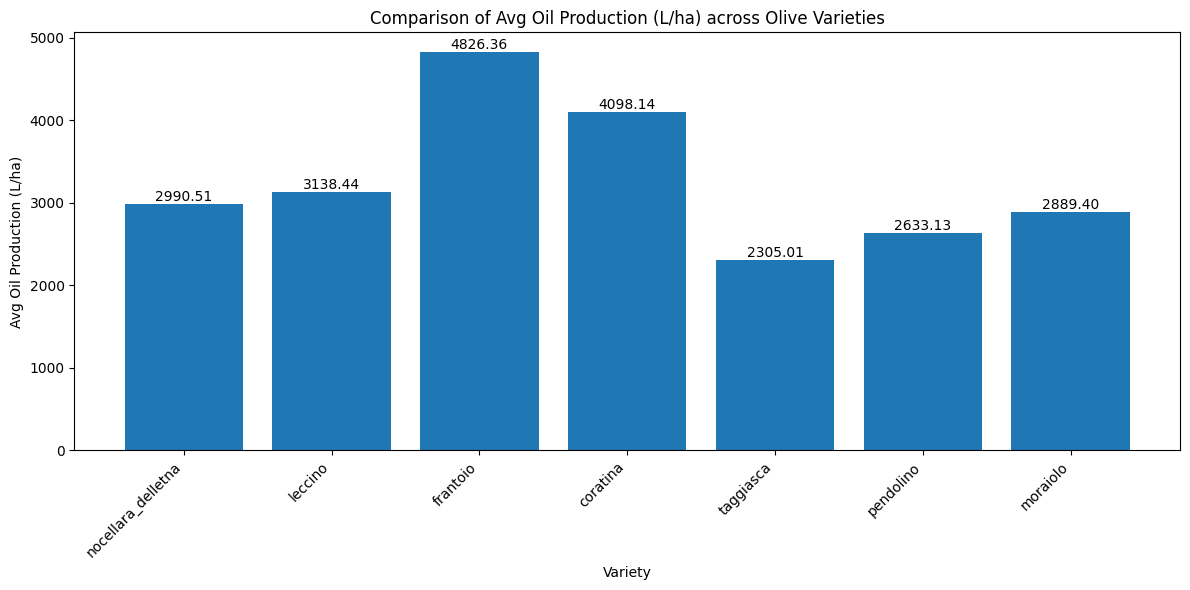

Plot salvato come: .//2024-12-08_14-47_plots/variety_comparison_avg_oil_production_l_ha.png


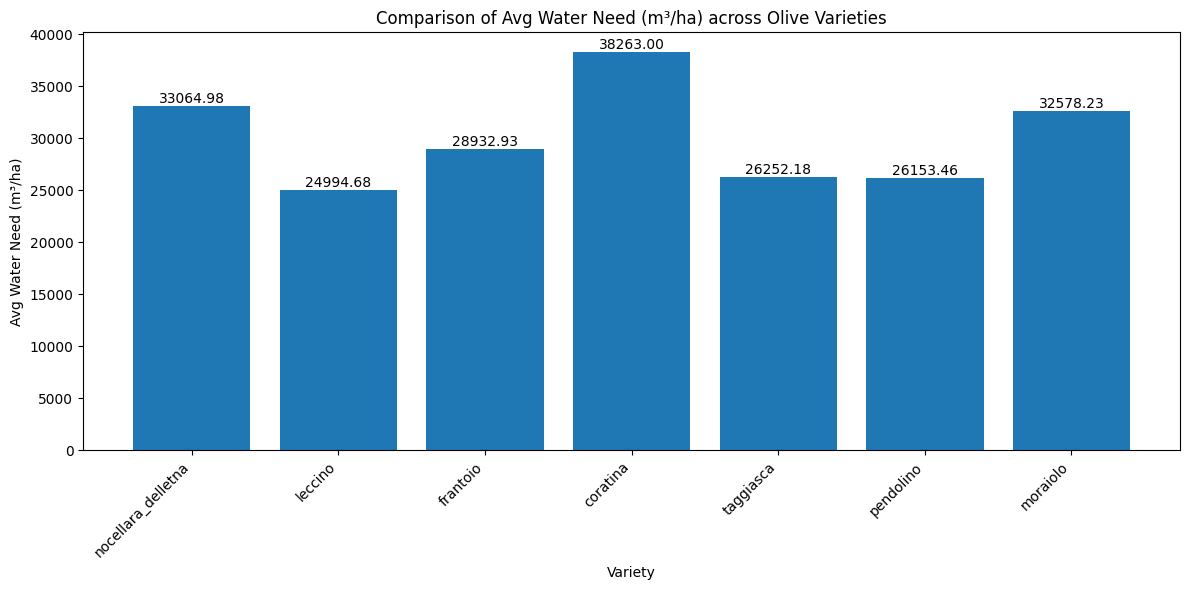

Plot salvato come: .//2024-12-08_14-47_plots/variety_comparison_avg_water_need_m³_ha.png


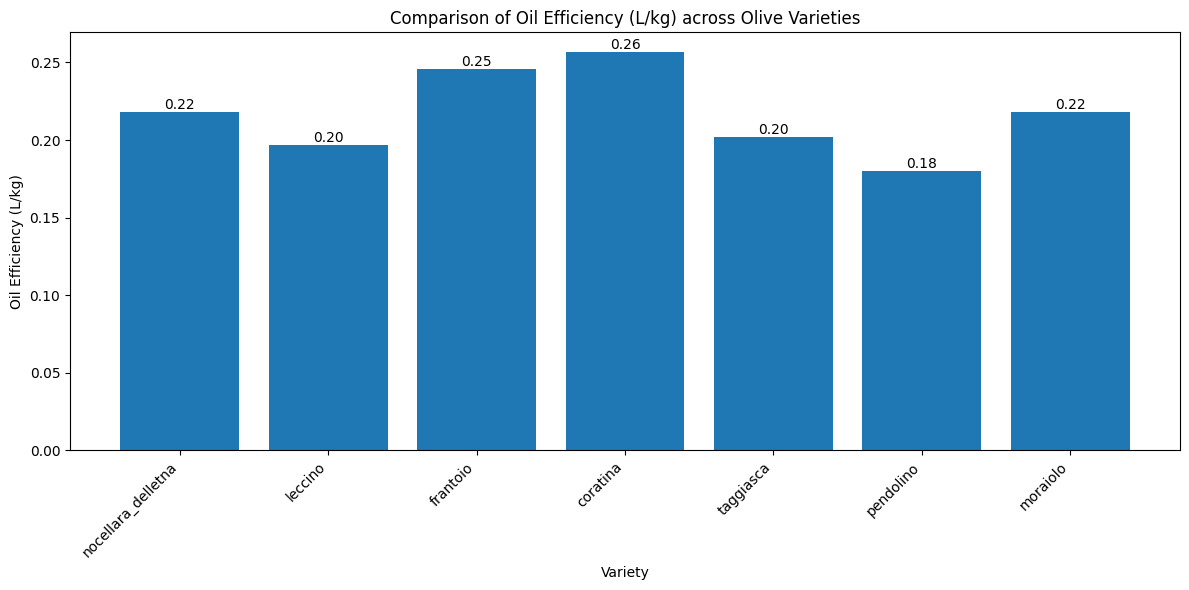

Plot salvato come: .//2024-12-08_14-47_plots/variety_comparison_oil_efficiency_l_kg.png


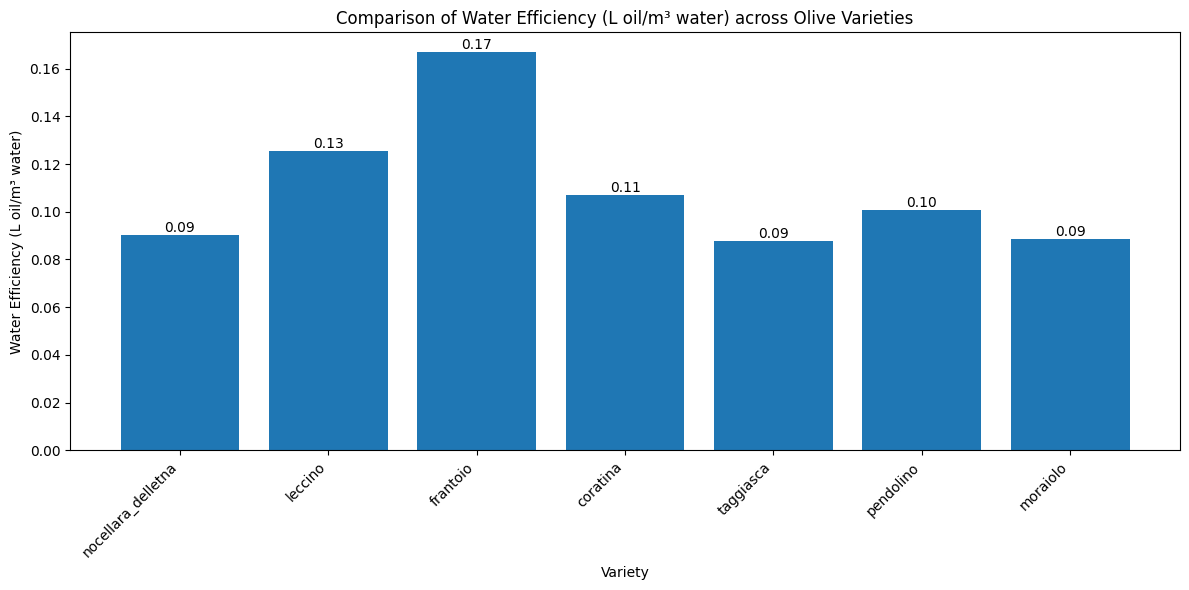

Plot salvato come: .//2024-12-08_14-47_plots/variety_comparison_water_efficiency_l_oil_m³_water.png
Plot salvato come: .//2024-12-08_14-47_plots/efficiency_vs_production.png


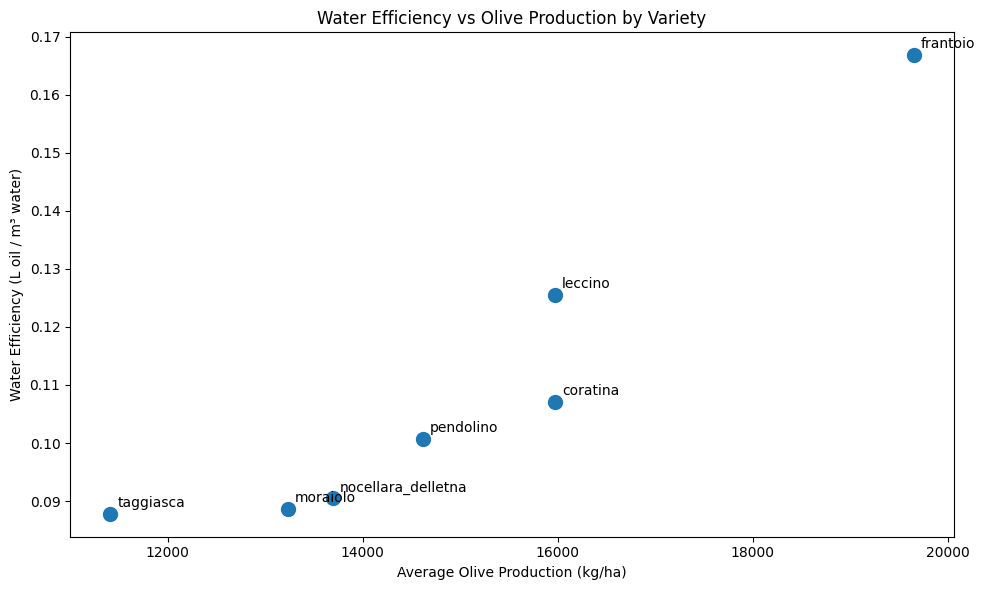

Plot salvato come: .//2024-12-08_14-47_plots/water_efficiency_vs_production.png


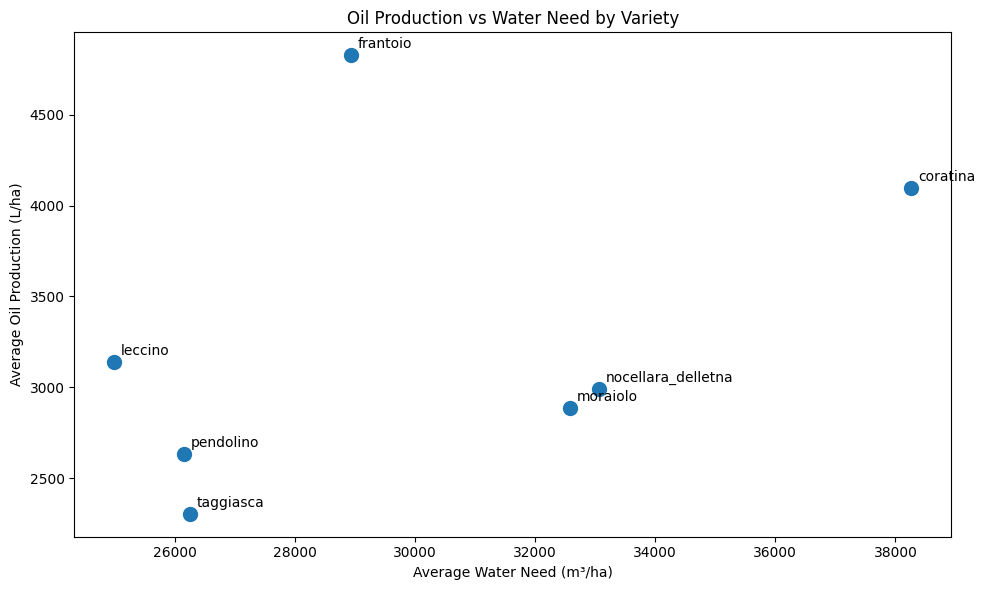

Plot salvato come: .//2024-12-08_14-47_plots/water_need_vs_oil_production.png
               Variety  Technique Technique String  \
0   nocellara_delletna          3     tradizionale   
1   nocellara_delletna          1        intensiva   
2   nocellara_delletna          2   superintensiva   
3              leccino          1        intensiva   
4              leccino          2   superintensiva   
5              leccino          3     tradizionale   
6             frantoio          2   superintensiva   
7             frantoio          3     tradizionale   
8             frantoio          1        intensiva   
9             coratina          1        intensiva   
10            coratina          2   superintensiva   
11            coratina          3     tradizionale   
12           taggiasca          3     tradizionale   
13           taggiasca          2   superintensiva   
14           taggiasca          1        intensiva   
15           pendolino          1        intensiva   
16  

In [7]:
simulated_data = pd.read_parquet(f"{data_dir}olive_training_dataset.parquet")
olive_varieties = pd.read_parquet(f"{data_dir}olive_varieties.parquet")
# Esecuzione dell'analisi
comparison_data = prepare_comparison_data(simulated_data, olive_varieties)

# Genera i grafici
plot_variety_comparison(comparison_data, 'Avg Olive Production (kg/ha)')
plot_variety_comparison(comparison_data, 'Avg Oil Production (L/ha)')
plot_variety_comparison(comparison_data, 'Avg Water Need (m³/ha)')
plot_variety_comparison(comparison_data, 'Oil Efficiency (L/kg)')
plot_variety_comparison(comparison_data, 'Water Efficiency (L oil/m³ water)')
plot_efficiency_vs_production(comparison_data)
plot_water_efficiency_vs_production(comparison_data)
plot_water_need_vs_oil_production(comparison_data)

technique_data = analyze_by_technique(simulated_data, olive_varieties)

print(technique_data)

# Stampa un sommario statistico
print("Comparison by Variety:")
print(comparison_data.set_index('Variety'))
print("\nBest Varieties by Water Efficiency:")
print(comparison_data.sort_values('Water Efficiency (L oil/m³ water)', ascending=False).head())

In [8]:
def prepare_transformer_data(df, olive_varieties_df):
    # Crea una copia del DataFrame per evitare modifiche all'originale
    df = df.copy()

    # Definisci le feature
    temporal_features = ['temp_mean', 'precip_sum', 'solar_energy_sum']
    static_features = ['ha']  # Feature statiche base
    target_features = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 'avg_oil_prod', 'total_water_need']

    # Ottieni le varietà pulite
    all_varieties = olive_varieties_df['Varietà di Olive'].unique()
    varieties = [clean_column_name(variety) for variety in all_varieties]

    # Crea la struttura delle feature per ogni varietà
    variety_features = [
        'tech', 'pct', 'prod_t_ha', 'oil_prod_t_ha', 'oil_prod_l_ha',
        'min_yield_pct', 'max_yield_pct', 'min_oil_prod_l_ha', 'max_oil_prod_l_ha',
        'avg_oil_prod_l_ha', 'l_per_t', 'min_l_per_t', 'max_l_per_t', 'avg_l_per_t'
    ]

    # Prepara dizionari per le nuove colonne
    new_columns = {}

    # Prepara le feature per ogni varietà
    for variety in varieties:
        # Feature esistenti
        for feature in variety_features:
            col_name = f"{variety}_{feature}"
            if col_name in df.columns:
                if feature != 'tech':  # Non includere la colonna tech direttamente
                    static_features.append(col_name)

        # Feature binarie per le tecniche di coltivazione
        for technique in ['tradizionale', 'intensiva', 'superintensiva']:
            col_name = f"{variety}_{technique}"
            new_columns[col_name] = df[f"{variety}_tech"].notna() & (
                    df[f"{variety}_tech"].str.lower() == technique
            ).fillna(False)
            static_features.append(col_name)

    # Aggiungi tutte le nuove colonne in una volta sola
    df = pd.concat([df] + [pd.Series(v, name=k) for k, v in new_columns.items()], axis=1)

    # Prepara X e y
    X_temporal = df[temporal_features].values
    X_static = df[static_features].values
    y = df[target_features].values

    print(f"Dataset completo - Temporal: {X_temporal.shape}, Static: {X_static.shape}, Target: {y.shape}")

    # Split dei dati (usando indici casuali per una migliore distribuzione)
    indices = np.random.permutation(len(X_temporal))
    train_idx = int(len(indices) * 0.65)    # 65% training
    val_idx = int(len(indices) * 0.85)      # 20% validation
    # Il resto rimane 15% test

    train_indices = indices[:train_idx]
    val_indices = indices[train_idx:val_idx]
    test_indices = indices[val_idx:]

    # Split dei dati
    X_temporal_train = X_temporal[train_indices]
    X_temporal_val = X_temporal[val_indices]
    X_temporal_test = X_temporal[test_indices]

    X_static_train = X_static[train_indices]
    X_static_val = X_static[val_indices]
    X_static_test = X_static[test_indices]

    y_train = y[train_indices]
    y_val = y[val_indices]
    y_test = y[test_indices]

    # Standardizzazione
    scaler_temporal = StandardScaler()
    scaler_static = StandardScaler()
    scaler_y = StandardScaler()

    # Standardizzazione dei dati
    X_temporal_train = scaler_temporal.fit_transform(X_temporal_train)
    X_temporal_val = scaler_temporal.transform(X_temporal_val)
    X_temporal_test = scaler_temporal.transform(X_temporal_test)

    X_static_train = scaler_static.fit_transform(X_static_train)
    X_static_val = scaler_static.transform(X_static_val)
    X_static_test = scaler_static.transform(X_static_test)

    y_train = scaler_y.fit_transform(y_train)
    y_val = scaler_y.transform(y_val)
    y_test = scaler_y.transform(y_test)

    print("\nShape dopo lo split e standardizzazione:")
    print(f"Train - Temporal: {X_temporal_train.shape}, Static: {X_static_train.shape}, Target: {y_train.shape}")
    print(f"Val - Temporal: {X_temporal_val.shape}, Static: {X_static_val.shape}, Target: {y_val.shape}")
    print(f"Test - Temporal: {X_temporal_test.shape}, Static: {X_static_test.shape}, Target: {y_test.shape}")

    # Reshape per il transformer (aggiunge la dimensione del sequence length = 1)
    X_temporal_train = X_temporal_train.reshape(X_temporal_train.shape[0], 1, -1)
    X_temporal_val = X_temporal_val.reshape(X_temporal_val.shape[0], 1, -1)
    X_temporal_test = X_temporal_test.reshape(X_temporal_test.shape[0], 1, -1)

    # Prepara i dizionari di input
    train_data = {'temporal': X_temporal_train, 'static': X_static_train}
    val_data = {'temporal': X_temporal_val, 'static': X_static_val}
    test_data = {'temporal': X_temporal_test, 'static': X_static_test}

    # Salva gli scaler
    joblib.dump(scaler_temporal, os.path.join(base_project_dir, f'{execute_name}_scaler_temporal.joblib'))
    joblib.dump(scaler_static, os.path.join(base_project_dir, f'{execute_name}_scaler_static.joblib'))
    joblib.dump(scaler_y, os.path.join(base_project_dir, f'{execute_name}_scaler_y.joblib'))

    return (train_data, y_train), (val_data, y_val), (test_data, y_test), (scaler_temporal, scaler_static, scaler_y)

In [9]:
simulated_data = pd.read_parquet(f"{data_dir}olive_training_dataset.parquet")
olive_varieties = pd.read_parquet(f"{data_dir}olive_varieties.parquet")

(train_data, train_targets), (val_data, val_targets), (test_data, test_targets), scalers = prepare_transformer_data(simulated_data, olive_varieties)

scaler_temporal, scaler_static, scaler_y = scalers

print("Temporal data shape:", train_data['temporal'].shape)
print("Static data shape:", train_data['static'].shape)
print("Target shape:", train_targets.shape)

Dataset completo - Temporal: (4000000, 3), Static: (4000000, 113), Target: (4000000, 5)

Shape dopo lo split e standardizzazione:
Train - Temporal: (2600000, 3), Static: (2600000, 113), Target: (2600000, 5)
Val - Temporal: (800000, 3), Static: (800000, 113), Target: (800000, 5)
Test - Temporal: (600000, 3), Static: (600000, 113), Target: (600000, 5)
Temporal data shape: (2600000, 1, 3)
Static data shape: (2600000, 113)
Target shape: (2600000, 5)


In [10]:
@keras.saving.register_keras_serializable()
class DataAugmentation(tf.keras.layers.Layer):
    """Custom layer per l'augmentation dei dati"""

    def __init__(self, noise_stddev=0.03, **kwargs):
        super().__init__(**kwargs)
        self.noise_stddev = noise_stddev

    def call(self, inputs, training=None):
        if training:
            return inputs + tf.random.normal(
                shape=tf.shape(inputs),
                mean=0.0,
                stddev=self.noise_stddev
            )
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({"noise_stddev": self.noise_stddev})
        return config


@keras.saving.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    """Custom layer per l'encoding posizionale"""

    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model

    def build(self, input_shape):
        _, seq_length, _ = input_shape

        # Crea la matrice di encoding posizionale
        position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, self.d_model, 2, dtype=tf.float32) *
            (-tf.math.log(10000.0) / self.d_model)
        )

        # Calcola sin e cos
        pos_encoding = tf.zeros((1, seq_length, self.d_model))
        pos_encoding_even = tf.sin(position * div_term)
        pos_encoding_odd = tf.cos(position * div_term)

        # Assegna i valori alle posizioni pari e dispari
        pos_encoding = tf.concat(
            [tf.expand_dims(pos_encoding_even, -1),
             tf.expand_dims(pos_encoding_odd, -1)],
            axis=-1
        )
        pos_encoding = tf.reshape(pos_encoding, (1, seq_length, -1))
        pos_encoding = pos_encoding[:, :, :self.d_model]

        # Salva l'encoding come peso non trainabile
        self.pos_encoding = self.add_weight(
            shape=(1, seq_length, self.d_model),
            initializer=tf.keras.initializers.Constant(pos_encoding),
            trainable=False,
            name='positional_encoding'
        )

        super().build(input_shape)

    def call(self, inputs):
        # Broadcast l'encoding posizionale sul batch
        batch_size = tf.shape(inputs)[0]
        pos_encoding_tiled = tf.tile(self.pos_encoding, [batch_size, 1, 1])
        return inputs + pos_encoding_tiled

    def get_config(self):
        config = super().get_config()
        config.update({"d_model": self.d_model})
        return config


@keras.saving.register_keras_serializable()
class WarmUpLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """Custom learning rate schedule with linear warmup and exponential decay."""

    def __init__(self, initial_learning_rate=1e-3, warmup_steps=500, decay_steps=5000):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def __call__(self, step):
        warmup_pct = tf.cast(step, tf.float32) / self.warmup_steps
        warmup_lr = self.initial_learning_rate * warmup_pct
        decay_factor = tf.pow(0.1, tf.cast(step, tf.float32) / self.decay_steps)
        decayed_lr = self.initial_learning_rate * decay_factor
        return tf.where(step < self.warmup_steps, warmup_lr, decayed_lr)

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'warmup_steps': self.warmup_steps,
            'decay_steps': self.decay_steps
        }


def create_olive_oil_transformer(temporal_shape, static_shape, num_outputs,
                                 d_model=128, num_heads=8, ff_dim=256,
                                 num_transformer_blocks=4, mlp_units=None,
                                 dropout=0.2):
    if mlp_units is None:
        mlp_units = [256, 128, 64]

    temporal_input = tf.keras.layers.Input(shape=temporal_shape, name='temporal')
    static_input = tf.keras.layers.Input(shape=static_shape, name='static')

    # === TEMPORAL PATH ===
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(temporal_input)
    x = DataAugmentation()(x)

    # Temporal projection con dimensione aumentata per compensare la sequenza corta
    x = tf.keras.layers.Dense(
        d_model,
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    # Additional feature extraction prima del transformer
    x = tf.keras.layers.Dense(
        d_model * 2,
        activation='swish',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(x)

    x = PositionalEncoding(d_model * 2)(x)

    skip_connection = x
    for _ in range(num_transformer_blocks):
        # Multi-head self-attention con più heads per compensare la sequenza corta
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads * 2,
            key_dim=d_model // num_heads,
            value_dim=d_model // num_heads
        )(x, x)
        attention_output = tf.keras.layers.Dropout(dropout)(attention_output)

        # Residual connection con gating mechanism
        gate = tf.keras.layers.Dense(d_model * 2, activation='sigmoid')(x)
        x = x + gate * attention_output
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network potenziato
        ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim * 2, activation="swish"),  # Raddoppiato
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(ff_dim, activation="swish"),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(d_model * 2)
        ])
        ffn_output = ffn(x)

        # Gated residual connection
        gate = tf.keras.layers.Dense(d_model * 2, activation='sigmoid')(x)
        x = x + gate * ffn_output
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # Global feature attention
    x = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads
    )(x, x)

    # Feature pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # === STATIC PATH ===
    s = tf.keras.layers.LayerNormalization(epsilon=1e-6)(static_input)
    for units in [512, 256, 128]:  # Aumentate le dimensioni
        s = tf.keras.layers.Dense(
            units,
            activation='swish',
            kernel_regularizer=tf.keras.regularizers.l2(1e-5)
        )(s)
        s = tf.keras.layers.BatchNormalization()(s)
        s = tf.keras.layers.Dropout(dropout)(s)


    # === FEATURE FUSION con attention ===
    # Project features to same dimensionality
    x = tf.keras.layers.Dense(256)(x)
    s = tf.keras.layers.Dense(256)(s)

    # Cross-attention between temporal and static features
    combined = tf.keras.layers.Concatenate()([x, s])
    combined = tf.keras.layers.Dense(256, activation='swish')(combined)

    # MLP head with residual connections
    for units in mlp_units:
        skip = combined
        combined = tf.keras.layers.BatchNormalization()(combined)
        combined = tf.keras.layers.Dense(units, activation="swish")(combined)
        combined = tf.keras.layers.Dropout(dropout)(combined)
        if units == skip.shape[-1]:  # Se le dimensioni combaciano
            combined = combined + skip

    # Apply final normalization to output
    outputs = tf.keras.layers.BatchNormalization()(combined)
    outputs = tf.keras.layers.Dense(
        num_outputs,
        activation='linear',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    )(outputs)

    # Create model
    model = tf.keras.Model(
        inputs={'temporal': temporal_input, 'static': static_input},
        outputs=outputs,
        name='OilTransformer'
    )

    return model


def create_transformer_callbacks(target_names, val_data, val_targets):
    """
    Crea i callbacks per il training del modello single-step.
    """
    class TargetSpecificMetric(tf.keras.callbacks.Callback):
        def __init__(self, validation_data, target_names):
            super().__init__()
            self.validation_data = validation_data
            self.target_names = target_names
            self.best_metrics = {name: float('inf') for name in target_names}
    
        def on_epoch_end(self, epoch, logs=None):
            logs = logs or {}
            
            # Esegui il calcolo solo ogni 5 epoche
            if epoch % 5 == 0:
                x_val, y_val = self.validation_data
                y_pred = self.model.predict(x_val, verbose=0)
    
                # Calcola e logga le metriche per ogni target
                for i, name in enumerate(self.target_names):
                    mae = np.mean(np.abs(y_val[:, i] - y_pred[:, i]))
                    mape = np.mean(np.abs((y_val[:, i] - y_pred[:, i]) / np.clip(np.abs(y_val[:, i]), 1e-7, None))) * 100
                    logs[f'val_{name}_mae'] = mae
                    logs[f'val_{name}_mape'] = mape
    
                    # Traccia i migliori risultati
                    if mae < self.best_metrics[name]:
                        self.best_metrics[name] = mae
                        logs[f'best_{name}_mae'] = mae


    callbacks = [
        # Early Stopping ottimizzato
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=25,  # Aumentato per dare più chance al modello
            restore_best_weights=True,
            min_delta=0.0001,  # Più sensibile ai miglioramenti
            mode='min'
        ),

        # Model Checkpoint con monitoraggio multiplo
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{execute_name}_best_oil_model.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            save_weights_only=True
        ),

        # Metric per target specifici
        TargetSpecificMetric(
            validation_data=(val_data, val_targets),
            target_names=target_names
        ),

        # LR reduction ottimizzato per single-step
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,  # Riduzione più aggressiva
            patience=15,
            min_lr=1e-7,
            verbose=1,
            cooldown=5  # Periodo di cool-down per stabilizzazione
        ),

        # TensorBoard con più metriche
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs_{execute_name}',
            histogram_freq=1,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            profile_batch='500,520'  # Profile per ottimizzazione
        )
    ]

    return callbacks

def compile_model(model, learning_rate=5e-4):  # Learning rate ridotto
    """
    Compila il modello con ottimizzazioni per single-step.
    """
    lr_schedule = WarmUpLearningRateSchedule(
        initial_learning_rate=learning_rate,
        warmup_steps=1000,  # Aumentato per stabilità
        decay_steps=7000    # Aumentato per permettere più esplorazione
    )

    def weighted_huber_loss(y_true, y_pred):
        # Pesi per diversi output
        weights = tf.constant([1.0, 0.8, 0.8, 1.0, 0.6], dtype=tf.float32)
        huber = tf.keras.losses.Huber(delta=1.0)
        loss = huber(y_true, y_pred)
        weighted_loss = tf.reduce_mean(loss * weights)
        return weighted_loss

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=0.01,
            clipnorm=1.0,  # Gradient clipping
            epsilon=1e-7    # Aumentato per stabilità numerica
        ),
        loss=weighted_huber_loss,
        metrics=['mae', 'mape']
    )

    return model

def setup_transformer_training(train_data, train_targets, val_data, val_targets):
    """
    Configura il single-step transformer.
    """
    # Estrai le shape dai dati
    temporal_shape = (1, train_data['temporal'].shape[2])
    static_shape = (train_data['static'].shape[1],)
    num_outputs = train_targets.shape[1]

    print(f"Shape rilevate:")
    print(f"- Temporal shape: {temporal_shape}")
    print(f"- Static shape: {static_shape}")
    print(f"- Numero di output: {num_outputs}")

    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 'avg_oil_prod', 'total_water_need']

    assert len(target_names) == num_outputs, \
        f"Il numero di target names ({len(target_names)}) non corrisponde al numero di output ({num_outputs})"

    # Crea il modello con il nuovo transformer
    model = create_olive_oil_transformer(
        temporal_shape=temporal_shape,
        static_shape=static_shape,
        num_outputs=num_outputs,
        d_model=256,
        num_heads=8,
        ff_dim=512,
        num_transformer_blocks=6,
        dropout=0.1
    )

    model = compile_model(model)
    callbacks = create_transformer_callbacks(target_names, val_data, val_targets)

    return model, callbacks, target_names

def train_transformer(train_data, train_targets, val_data, val_targets, epochs=200, batch_size=128, save_name='final_model'):
    """
    Training ottimizzato per single-step transformer.
    """
    # Dataset con augmentation
    def augment(x, y):
        # Ottieni il dtype dei dati originali
        original_dtype = x['temporal'].dtype
        # Genera il rumore con lo stesso dtype
        noise = tf.random.normal(
            tf.shape(x['temporal']), 
            mean=0.0, 
            stddev=0.01,
            dtype=original_dtype
        )
        x['temporal'] += noise
        return x, y

    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_targets))\
        .map(augment, num_parallel_calls=tf.data.AUTOTUNE)\
        .cache()\
        .shuffle(buffer_size=10000)\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_targets))\
        .cache()\
        .batch(batch_size)\
        .prefetch(tf.data.AUTOTUNE)

    strategy = tf.distribute.MirroredStrategy() if len(tf.config.list_physical_devices('GPU')) > 1 else tf.distribute.get_strategy()

    with strategy.scope():
        model, callbacks, target_names = setup_transformer_training(
            train_data, train_targets, val_data, val_targets
        )

    model.summary()

    try:
        keras.utils.plot_model(model, f"{execute_name}_{save_name}.png", show_shapes=True)
    except Exception as e:
        print(f"Warning: Could not create model plot: {e}")

    # Training con gestione errori e memory saving
    try:
        with tf.device('/GPU:0'):  # Forza l'uso della GPU principale
            history = model.fit(
                train_dataset,
                validation_data=val_dataset,
                epochs=epochs,
                callbacks=callbacks,
                verbose=1,
                workers=8,
                use_multiprocessing=True
            )
    except tf.errors.ResourceExhaustedError:
        print("Memoria GPU esaurita, riprovo con batch size più piccolo...")
        batch_size = batch_size // 2
        train_dataset = train_dataset.unbatch().batch(batch_size)
        val_dataset = val_dataset.unbatch().batch(batch_size)
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

    # Salvataggio modello
    try:
        save_path = f'{execute_name}_{save_name}.keras'
        model.save(save_path, save_format='keras')

        os.makedirs(f'{execute_name}/weights', exist_ok=True)
        model.save_weights(f'{execute_name}/weights')
        print(f"\nModello salvato in: {save_path}")

        # Salva anche la storia del training
        with open(f'{execute_name}_training_history.json', 'w') as f:
            json.dump(history.history, f)
    except Exception as e:
        print(f"Warning: Could not save model: {e}")

    return model, history

In [11]:
model, history = train_transformer(train_data, train_targets, val_data, val_targets, 200, 32768)

Shape rilevate:
- Temporal shape: (1, 3)
- Static shape: (113,)
- Numero di output: 5


2024-12-08 14:50:03.536829: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "OilTransformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 temporal (InputLayer)       [(None, 1, 3)]               0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 1, 3)                 6         ['temporal[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 data_augmentation (DataAug  (None, 1, 3)                 0         ['layer_normalization[0][0]'] 
 mentation)                                                                                       
                                                                                     

2024-12-08 14:50:05.929229: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-08 14:50:05.929268: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-12-08 14:50:05.929313: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1694] Profiler found 1 GPUs
2024-12-08 14:50:05.963777: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-12-08 14:50:05.963883: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1828] CUPTI activity buffer flushed


Epoch 1/200


2024-12-08 14:50:28.629786: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x773b6d05ca80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-08 14:50:28.629849: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-12-08 14:50:28.638389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-08 14:50:28.698504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-08 14:50:28.846260: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 336s 4s/step - loss: 0.6468 - mae: 1.1652 - mape: 1425.9640 - val_loss: 0.3750 - val_mae: 0.8167 - val_mape: 357.5072 - val_olive_prod_mae: 0.8317 - val_olive_prod_mape: 540.9344 - best_olive_prod_mae: 0.8317 - val_min_oil_prod_mae: 0.8388 - val_min_oil_prod_mape: 440.9449 - best_min_oil_prod_mae: 0.8388 - val_max_oil_prod_mae: 0.7774 - val_max_oil_prod_mape: 197.5839 - best_max_oil_prod_mae: 0.7774 - val_avg_oil_prod_mae: 0.7770 - val_avg_oil_prod_mape: 158.8580 - best_avg_oil_prod_mae: 0.7770 - val_total_water_need_mae: 0.8589 - val_total_water_need_mape: 449.2141 - best_total_water_need_mae: 0.8589 - lr: 3.9500e-05
Epoch 2/200
80/80 [==============================] - 37s 447ms/step - loss: 0.2883 - mae: 0.6758 - mape: 853.8861 - val_loss: 0.3493 - val_mae: 0.7684 - val_mape: 759.7661 - lr: 7.9500e-05
Epoch 3/200
80/80 [==============================] - 37s 450ms/step - loss: 0.1705 - mae: 0.4817 - mape: 538.0516 - val_loss: 0.2085 - val_mae: 

2024-12-08 15:02:15.855854: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-08 15:02:15.855911: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


39/80 [=============>................] - ETA: 14s - loss: 0.0594 - mae: 0.2364 - mape: 234.2973

2024-12-08 15:02:23.478578: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-12-08 15:02:23.647243: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1828] CUPTI activity buffer flushed
2024-12-08 15:02:27.754232: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 110980 callback api events and 111545 activity events. 
2024-12-08 15:03:20.421265: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


80/80 [==============================] - 96s 1s/step - loss: 0.0577 - mae: 0.2319 - mape: 262.5403 - val_loss: 0.1514 - val_mae: 0.4553 - val_mape: 361.8612 - lr: 2.7950e-04
Epoch 8/200
80/80 [==============================] - 36s 437ms/step - loss: 0.0537 - mae: 0.2191 - mape: 247.8973 - val_loss: 0.0820 - val_mae: 0.3394 - val_mape: 311.3165 - lr: 3.1950e-04
Epoch 9/200
80/80 [==============================] - 36s 439ms/step - loss: 0.0457 - mae: 0.1994 - mape: 220.3584 - val_loss: 0.0261 - val_mae: 0.1699 - val_mape: 192.3138 - lr: 3.5950e-04
Epoch 10/200
80/80 [==============================] - 35s 436ms/step - loss: 0.0398 - mae: 0.1852 - mape: 238.8312 - val_loss: 0.0632 - val_mae: 0.3179 - val_mape: 472.3796 - lr: 3.9950e-04
Epoch 11/200
80/80 [==============================] - 242s 3s/step - loss: 0.0380 - mae: 0.1785 - mape: 226.0223 - val_loss: 0.0411 - val_mae: 0.2068 - val_mape: 289.5609 - val_olive_prod_mae: 0.2628 - val_olive_prod_mape: 305.8365 - best_olive_prod_mae: 0.2

In [12]:
percentage_errors, absolute_errors = calculate_real_error(model, val_data, val_targets, scaler_y)

25000/25000 [==============================] - 211s 8ms/step

Errori per target:
--------------------------------------------------
olive_prod:
MAE assoluto: 1413.43
Errore percentuale medio: 5.47%
Precisione: 94.53%
--------------------------------------------------
min_oil_prod:
MAE assoluto: 290.38
Errore percentuale medio: 5.54%
Precisione: 94.46%
--------------------------------------------------
max_oil_prod:
MAE assoluto: 352.04
Errore percentuale medio: 5.57%
Precisione: 94.43%
--------------------------------------------------
avg_oil_prod:
MAE assoluto: 308.69
Errore percentuale medio: 5.37%
Precisione: 94.63%
--------------------------------------------------
total_water_need:
MAE assoluto: 1450.19
Errore percentuale medio: 3.24%
Precisione: 96.76%
--------------------------------------------------


In [13]:
def evaluate_model_performance(model, data, targets, set_name=""):
    """
    Valuta le performance del modello su un set di dati specifico.
    """
    predictions = model.predict(data, verbose=0)

    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 'avg_oil_prod', 'total_water_need']
    metrics = {}

    for i, name in enumerate(target_names):
        mae = np.mean(np.abs(targets[:, i] - predictions[:, i]))
        mse = np.mean(np.square(targets[:, i] - predictions[:, i]))
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((targets[:, i] - predictions[:, i]) / (targets[:, i] + 1e-7))) * 100

        metrics[f"{name}_mae"] = mae
        metrics[f"{name}_rmse"] = rmse
        metrics[f"{name}_mape"] = mape

    if set_name:
        print(f"\nPerformance sul set {set_name}:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    return metrics


def retrain_model(base_model, train_data, train_targets,
                  val_data, val_targets,
                  test_data, test_targets,
                  epochs=50, batch_size=128):
    """
    Implementa il retraining del modello con i dati combinati.
    """
    print("Valutazione performance iniziali del modello...")
    initial_metrics = {
        'train': evaluate_model_performance(base_model, train_data, train_targets, "training"),
        'val': evaluate_model_performance(base_model, val_data, val_targets, "validazione"),
        'test': evaluate_model_performance(base_model, test_data, test_targets, "test")
    }

    # Combina i dati per il retraining
    combined_data = {
        'temporal': np.concatenate([train_data['temporal'], val_data['temporal'], test_data['temporal']]),
        'static': np.concatenate([train_data['static'], val_data['static'], test_data['static']])
    }
    combined_targets = np.concatenate([train_targets, val_targets, test_targets])

    # Crea una nuova suddivisione per la validazione
    indices = np.arange(len(combined_targets))
    np.random.shuffle(indices)

    split_idx = int(len(indices) * 0.9)
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    # Prepara i dati per il retraining
    retrain_data = {k: v[train_idx] for k, v in combined_data.items()}
    retrain_targets = combined_targets[train_idx]
    retrain_val_data = {k: v[val_idx] for k, v in combined_data.items()}
    retrain_val_targets = combined_targets[val_idx]

    # Configura callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=0.0001
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{execute_name}_retrained_best_oil_model.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            save_weights_only=True
        )
    ]

    # Imposta learning rate per il fine-tuning
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000,
            decay_rate=0.9
        ),
        weight_decay=0.01
    )

    # Ricompila il modello con il nuovo optimizer
    base_model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=['mae']
    )

    print("\nAvvio retraining...")
    history = base_model.fit(
        retrain_data,
        retrain_targets,
        validation_data=(retrain_val_data, retrain_val_targets),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    print("\nValutazione performance finali...")
    final_metrics = {
        'train': evaluate_model_performance(base_model, train_data, train_targets, "training"),
        'val': evaluate_model_performance(base_model, val_data, val_targets, "validazione"),
        'test': evaluate_model_performance(base_model, test_data, test_targets, "test")
    }

    # Salva il modello finale
    save_path = f'{execute_name}_retrained_model.keras'
    os.makedirs(f'{execute_name}_retrained/weights', exist_ok=True)
    
    base_model.save_weights(f'{execute_name}_retrained/weights')
    base_model.save(save_path, save_format='keras')
    print(f"\nModello riaddestrato salvato in: {save_path}")

    # Report miglioramenti
    print("\nMiglioramenti delle performance:")
    for dataset in ['train', 'val', 'test']:
        print(f"\nSet {dataset}:")
        for metric in initial_metrics[dataset].keys():
            initial = initial_metrics[dataset][metric]
            final = final_metrics[dataset][metric]
            improvement = ((initial - final) / initial) * 100
            print(f"{metric}: {improvement:.2f}% di miglioramento")

    return base_model, history, final_metrics


def start_retraining(model_path, train_data, train_targets,
                     val_data, val_targets,
                     test_data, test_targets,
                     epochs=50, batch_size=128):
    """
    Avvia il processo di retraining in modo sicuro.
    """
    try:
        print("Caricamento del modello...")
        base_model = tf.keras.models.load_model(model_path, compile=False)
        print("Modello caricato con successo!")

        return retrain_model(
            base_model=base_model,
            train_data=train_data,
            train_targets=train_targets,
            val_data=val_data,
            val_targets=val_targets,
            test_data=test_data,
            test_targets=test_targets,
            epochs=epochs,
            batch_size=batch_size
        )
    except Exception as e:
        print(f"Errore durante il retraining: {str(e)}")
        raise

In [19]:
model_path = f'{execute_name}_final_model.keras'

retrained_model, retrain_history, final_metrics = start_retraining(
    model_path=model_path,
    train_data=train_data,
    train_targets=train_targets,
    val_data=val_data,
    val_targets=val_targets,
    test_data=test_data,
    test_targets=test_targets,
    epochs=100,
    batch_size=16384
)

Caricamento del modello...
Modello caricato con successo!
Valutazione performance iniziali del modello...

Performance sul set training:
olive_prod_mae: 0.0860
olive_prod_rmse: 0.1161
olive_prod_mape: 78.0493
min_oil_prod_mae: 0.0851
min_oil_prod_rmse: 0.1188
min_oil_prod_mape: 97.5077
max_oil_prod_mae: 0.0852
max_oil_prod_rmse: 0.1187
max_oil_prod_mape: 153.0588
avg_oil_prod_mae: 0.0819
avg_oil_prod_rmse: 0.1132
avg_oil_prod_mape: 133.1723
total_water_need_mae: 0.0489
total_water_need_rmse: 0.0645
total_water_need_mape: 49.3876

Performance sul set validazione:
olive_prod_mae: 0.0860
olive_prod_rmse: 0.1160
olive_prod_mape: 73.4536
min_oil_prod_mae: 0.0851
min_oil_prod_rmse: 0.1186
min_oil_prod_mape: 96.1195
max_oil_prod_mae: 0.0851
max_oil_prod_rmse: 0.1186
max_oil_prod_mape: 284.3090
avg_oil_prod_mae: 0.0818
avg_oil_prod_rmse: 0.1130
avg_oil_prod_mape: 66.9595
total_water_need_mae: 0.0489
total_water_need_rmse: 0.0644
total_water_need_mape: 41.5436

Performance sul set test:
olive_p

In [20]:
percentage_errors, absolute_errors = calculate_real_error(retrained_model, val_data, val_targets, scaler_y)

25000/25000 [==============================] - 247s 10ms/step

Errori per target:
--------------------------------------------------
olive_prod:
MAE assoluto: 1379.63
Errore percentuale medio: 5.07%
Precisione: 94.93%
--------------------------------------------------
min_oil_prod:
MAE assoluto: 278.96
Errore percentuale medio: 5.09%
Precisione: 94.91%
--------------------------------------------------
max_oil_prod:
MAE assoluto: 337.33
Errore percentuale medio: 5.13%
Precisione: 94.87%
--------------------------------------------------
avg_oil_prod:
MAE assoluto: 300.85
Errore percentuale medio: 4.98%
Precisione: 95.02%
--------------------------------------------------
total_water_need:
MAE assoluto: 1350.83
Errore percentuale medio: 2.90%
Precisione: 97.10%
--------------------------------------------------


In [21]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

def analyze_feature_importance(model: tf.keras.Model, 
                             test_data: dict, 
                             feature_names: List[str]) -> Dict[str, float]:
    """
    Analizza l'importanza delle feature usando perturbazione.
    
    Args:
        model: Modello TensorFlow addestrato
        test_data: Dizionario con chiavi 'temporal' e 'static' contenenti i dati
        feature_names: Lista dei nomi delle feature
        
    Returns:
        dict: Dizionario con l'importanza relativa di ogni feature
    """
    # Estrai i dati temporali e statici
    temporal_data = test_data['temporal']
    static_data = test_data['static']
    
    # Ottieni la predizione base
    base_prediction = model.predict(test_data)
    feature_importance = {}
    
    # Per ogni feature temporale
    for i, feature in enumerate(feature_names):
        if feature in ['temp_mean', 'precip_sum', 'solar_energy_sum']:
            # Crea copia perturbata dei dati
            perturbed_data = {
                'temporal': temporal_data.copy(),
                'static': static_data.copy()
            }
            
            # Trova l'indice della feature temporale
            temp_idx = ['temp_mean', 'precip_sum', 'solar_energy_sum'].index(feature)
            
            # Crea rumore per la feature temporale
            feature_values = temporal_data[..., temp_idx]
            noise = np.random.normal(0, np.std(feature_values) * 0.1, 
                                   size=feature_values.shape)
            
            # Applica il rumore alla feature temporale
            perturbed_temporal = perturbed_data['temporal'].copy()
            perturbed_temporal[..., temp_idx] = feature_values + noise
            perturbed_data['temporal'] = perturbed_temporal
            
        else:  # Feature statiche
            # Crea copia perturbata dei dati
            perturbed_data = {
                'temporal': temporal_data.copy(),
                'static': static_data.copy()
            }
            
            # Trova l'indice della feature statica
            static_idx = ['ha'].index(feature)
            
            # Crea rumore per la feature statica
            feature_values = static_data[..., static_idx]
            noise = np.random.normal(0, np.std(feature_values) * 0.1, 
                                   size=feature_values.shape)
            
            # Applica il rumore alla feature statica
            perturbed_static = perturbed_data['static'].copy()
            perturbed_static[..., static_idx] = feature_values + noise
            perturbed_data['static'] = perturbed_static
        
        # Calcola nuova predizione
        perturbed_prediction = model.predict(perturbed_data)
        
        # Calcola impatto della perturbazione
        impact = np.mean(np.abs(perturbed_prediction - base_prediction))
        feature_importance[feature] = float(impact)
    
    # Normalizza le importanze
    total_importance = sum(feature_importance.values())
    feature_importance = {k: v/total_importance 
                         for k, v in feature_importance.items()}
    
    return feature_importance

class ProbabilityFunctions:
    @staticmethod
    def calculate_statistics(data: Union[np.ndarray, tf.Tensor]) -> Dict[str, float]:
        """
        Calcola statistiche di base usando TensorFlow.
        
        Args:
            data: Tensor o array dei dati
            
        Returns:
            dict: Dizionario con le statistiche
        """
        if not isinstance(data, tf.Tensor):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
            
        mean = tf.reduce_mean(data)
        # Calcola varianza manualmente
        squared_deviations = tf.square(data - mean)
        variance = tf.reduce_mean(squared_deviations)
        std = tf.sqrt(variance)
        
        # Ordina il tensor per il calcolo della mediana
        sorted_data = tf.sort(data)
        size = tf.size(data)
        mid_index = size // 2
        median = sorted_data[mid_index]
        
        return {
            'mean': mean.numpy(),
            'variance': variance.numpy(),
            'std': std.numpy(),
            'min': tf.reduce_min(data).numpy(),
            'max': tf.reduce_max(data).numpy(),
            'median': median.numpy()
        }

    @staticmethod
    def calculate_pmf(data: np.ndarray, bins: int = 50) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calcola la Probability Mass Function (PMF) dei dati.
        
        Args:
            data: Array di dati
            bins: Numero di bin per l'istogramma
            
        Returns:
            tuple: (bin_centers, pmf, bin_edges)
        """
        # Calcola l'istogramma
        hist, bin_edges = np.histogram(data, bins=bins, density=True)
        
        # Calcola i centri dei bin
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Normalizza per ottenere la PMF
        pmf = hist / np.sum(hist)
        
        return bin_centers, pmf, bin_edges

    @staticmethod
    def calculate_cmf(pmf: np.ndarray) -> np.ndarray:
        """
        Calcola la Cumulative Mass Function (CMF) dalla PMF.
        
        Args:
            pmf: Probability Mass Function
            
        Returns:
            array: Cumulative Mass Function
        """
        return np.cumsum(pmf)

    def plot_distributions(self, data: np.ndarray, 
                         bins: int = 50, 
                         title: str = "Distribuzione") -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Calcola e visualizza PMF e CMF delle distribuzioni.
        
        Args:
            data: Array di dati da analizzare
            bins: Numero di bin per l'istogramma
            title: Titolo del grafico
            
        Returns:
            tuple: (bin_centers, pmf, cmf)
        """
        # Calcola PMF e CMF
        bin_centers, pmf, bin_edges = self.calculate_pmf(data, bins)
        cmf = self.calculate_cmf(pmf)
        
        # Crea il plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot PMF
        width = np.diff(bin_edges)
        ax1.bar(bin_centers, pmf, width=width, alpha=0.5, label='PMF')
        ax1.set_title('Probability Mass Function')
        ax1.set_ylabel('Probability')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot CMF
        ax2.plot(bin_centers, cmf, 'r-', label='CMF')
        ax2.set_title('Cumulative Mass Function')
        ax2.set_xlabel('Value')
        ax2.set_ylabel('Cumulative Probability')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Imposta il titolo generale
        fig.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()
        
        return bin_centers, pmf, cmf

def analyze_model_predictions(model: tf.keras.Model, 
                            test_data: np.ndarray,
                            test_targets: np.ndarray,
                            scaler_y) -> None:
    """
    Analizza le distribuzioni di probabilità delle predizioni del modello.
    
    Args:
        model: Modello TensorFlow addestrato
        test_data: Dati di test
        test_targets: Target di test
        scaler_y: Scaler usato per denormalizzare i target
    """
    # Ottieni le predizioni
    predictions = model.predict(test_data)
    
    # Denormalizza predizioni e target
    predictions_real = scaler_y.inverse_transform(predictions)
    targets_real = scaler_y.inverse_transform(test_targets)
    
    # Inizializza la classe per l'analisi delle probabilità
    prob = ProbabilityFunctions()
    
    # Analizza ogni target
    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 
                   'avg_oil_prod', 'total_water_need']
    
    for i, target in enumerate(target_names):
        print(f"\nAnalisi per {target}")
        print("-" * 50)
        
        # Calcola errori
        errors = predictions_real[:, i] - targets_real[:, i]
        
        # Calcola statistiche degli errori
        error_stats = prob.calculate_statistics(errors)
        print("\nStatistiche degli Errori:")
        for key, value in error_stats.items():
            print(f"{key}: {value:.3f}")
        
        # Visualizza le distribuzioni degli errori
        bin_centers, pmf, cmf = prob.plot_distributions(
            errors, 
            bins=50,
            title=f"Distribuzione degli Errori - {target}"
        )
        
        # Calcola intervalli di confidenza
        confidence_levels = [0.68, 0.95, 0.99]  # 1σ, 2σ, 3σ
        for level in confidence_levels:
            lower_idx = np.searchsorted(cmf, (1 - level) / 2)
            upper_idx = np.searchsorted(cmf, (1 + level) / 2)
            
            print(f"\nIntervallo di Confidenza {level*100}%:")
            print(f"Range: [{bin_centers[lower_idx]:.2f}, {bin_centers[upper_idx]:.2f}]")

def run_comprehensive_analysis(retrained_model, test_data, test_targets, scaler_y):
    """
    Esegue un'analisi completa del modello includendo errori,
    importanza delle feature e distribuzioni.
    """
    print("=== ANALISI COMPLETA DEL MODELLO ===")
    
    # 1. Analisi degli errori
    print("\n1. ANALISI DEGLI ERRORI")
    print("-" * 50)
    analyze_model_predictions(retrained_model, test_data, test_targets, scaler_y)
    
    # 2. Analisi dell'importanza delle feature
    print("\n2. IMPORTANZA DELLE FEATURE")
    print("-" * 50)
    
    # Definisci i nomi delle feature
    temporal_features = ['temp_mean', 'precip_sum', 'solar_energy_sum']
    static_features = ['ha']
    
    all_features = temporal_features + static_features
    importance = analyze_feature_importance(retrained_model, test_data, all_features)
    
    print("\nImportanza relativa delle feature:")
    for feature, imp in sorted(importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {imp:.4f}")
        
    # 3. Analisi distribuzionale
    print("\n3. ANALISI DISTRIBUZIONALE")
    print("-" * 50)
    
    prob = ProbabilityFunctions()
    predictions = retrained_model.predict(test_data)
    predictions_real = scaler_y.inverse_transform(predictions)
    targets_real = scaler_y.inverse_transform(test_targets)
    
    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 
                    'avg_oil_prod', 'total_water_need']
    
    for i, target in enumerate(target_names):
        print(f"\nAnalisi distribuzionale per {target}")
        
        # Statistiche
        stats_pred = prob.calculate_statistics(predictions_real[:, i])
        stats_true = prob.calculate_statistics(targets_real[:, i])
        
        print("\nStatistiche Predizioni:")
        for key, value in stats_pred.items():
            print(f"{key}: {value:.3f}")
            
        print("\nStatistiche Target Reali:")
        for key, value in stats_true.items():
            print(f"{key}: {value:.3f}")
        
        # Visualizza distribuzioni
        prob.plot_distributions(predictions_real[:, i], bins=50,
                              title=f"Distribuzione Predizioni - {target}")
        prob.plot_distributions(targets_real[:, i], bins=50,
                              title=f"Distribuzione Target Reali - {target}")

def analyze_model_predictions(model, test_data, test_targets, scaler_y):
    """
    Analizza le distribuzioni di probabilità delle predizioni del modello.
    
    Args:
        model: Modello TensorFlow addestrato
        test_data: Dati di test
        test_targets: Target di test
        scaler_y: Scaler usato per denormalizzare i target
    """
    # Ottieni le predizioni
    predictions = model.predict(test_data)
    
    # Denormalizza predizioni e target
    predictions_real = scaler_y.inverse_transform(predictions)
    targets_real = scaler_y.inverse_transform(test_targets)
    
    # Inizializza la classe per l'analisi delle probabilità
    prob = ProbabilityFunctions()
    
    # Analizza ogni target
    target_names = ['olive_prod', 'min_oil_prod', 'max_oil_prod', 
                   'avg_oil_prod', 'total_water_need']
    
    for i, target in enumerate(target_names):
        print(f"\nAnalisi per {target}")
        print("-" * 50)
        
        # Calcola errori
        errors = predictions_real[:, i] - targets_real[:, i]
        
        # Calcola statistiche degli errori
        error_stats = prob.calculate_statistics(errors)
        print("\nStatistiche degli Errori:")
        for key, value in error_stats.items():
            print(f"{key}: {value:.3f}")
        
        # Visualizza le distribuzioni degli errori
        bin_centers, pmf, cmf = prob.plot_distributions(
            errors, 
            bins=50,
            title=f"Distribuzione degli Errori - {target}"
        )
        
        # Calcola intervalli di confidenza
        confidence_levels = [0.80,0.85, 0.90, 0.95, 0.99]  # 1σ, 2σ, 3σ
        for level in confidence_levels:
            lower_idx = np.searchsorted(cmf, (1 - level) / 2)
            upper_idx = np.searchsorted(cmf, (1 + level) / 2)
            
            print(f"\nIntervallo di Confidenza {level*100}%:")
            print(f"Range: [{bin_centers[lower_idx]:.2f}, {bin_centers[upper_idx]:.2f}]")

class ProbabilityFunctions:
    @staticmethod
    def calculate_statistics(data):
        """
        Calcola statistiche di base usando TensorFlow.
        
        Args:
            data: Tensor dei dati
            
        Returns:
            dict: Dizionario con le statistiche
        """
        if not isinstance(data, tf.Tensor):
            data = tf.convert_to_tensor(data, dtype=tf.float32)
            
        mean = tf.reduce_mean(data)
        # Calculate variance manually
        squared_deviations = tf.square(data - mean)
        variance = tf.reduce_mean(squared_deviations)
        std = tf.sqrt(variance)
        
        # Sort the tensor for median calculation
        sorted_data = tf.sort(data)
        size = tf.size(data)
        mid_index = size // 2
        median = sorted_data[mid_index]
        
        return {
            'mean': mean.numpy(),
            'variance': variance.numpy(),
            'std': std.numpy(),
            'min': tf.reduce_min(data).numpy(),
            'max': tf.reduce_max(data).numpy(),
            'median': median.numpy()
        }

    @staticmethod
    def calculate_pmf(data, bins=50):
        """
        Calcola la Probability Mass Function (PMF) dei dati.
        
        Args:
            data: Array di dati
            bins: Numero di bin per l'istogramma
            
        Returns:
            tuple: (bin_centers, pmf, bin_edges)
        """
        # Calcola l'istogramma
        hist, bin_edges = np.histogram(data, bins=bins, density=True)
        
        # Calcola i centri dei bin
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Normalizza per ottenere la PMF
        pmf = hist / np.sum(hist)
        
        return bin_centers, pmf, bin_edges

    @staticmethod
    def calculate_cmf(pmf):
        """
        Calcola la Cumulative Mass Function (CMF) dalla PMF.
        
        Args:
            pmf: Probability Mass Function
            
        Returns:
            array: Cumulative Mass Function
        """
        return np.cumsum(pmf)

    def plot_distributions(self, data, bins=50, title="Distribuzione"):
        """
        Calcola e visualizza PMF e CMF delle distribuzioni.
        
        Args:
            data: Array di dati da analizzare
            bins: Numero di bin per l'istogramma
            title: Titolo del grafico
            
        Returns:
            tuple: (bin_centers, pmf, cmf)
        """
        # Calcola PMF e CMF
        bin_centers, pmf, bin_edges = self.calculate_pmf(data, bins)
        cmf = self.calculate_cmf(pmf)
        
        # Crea il plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Plot PMF
        width = np.diff(bin_edges)
        ax1.bar(bin_centers, pmf, width=width, alpha=0.5, label='PMF')
        ax1.set_title('Probability Mass Function')
        ax1.set_ylabel('Probability')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Plot CMF
        ax2.plot(bin_centers, cmf, 'r-', label='CMF')
        ax2.set_title('Cumulative Mass Function')
        ax2.set_xlabel('Value')
        ax2.set_ylabel('Cumulative Probability')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Set overall title
        fig.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()
        
        return bin_centers, pmf, cmf

=== ANALISI COMPLETA DEL MODELLO ===

1. ANALISI DEGLI ERRORI
--------------------------------------------------
18750/18750 [==============================] - 191s 10ms/step

Analisi per olive_prod
--------------------------------------------------

Statistiche degli Errori:
mean: 16.634
variance: 3545753.250
std: 1883.017
min: -15594.572
max: 14395.641
median: 192.294


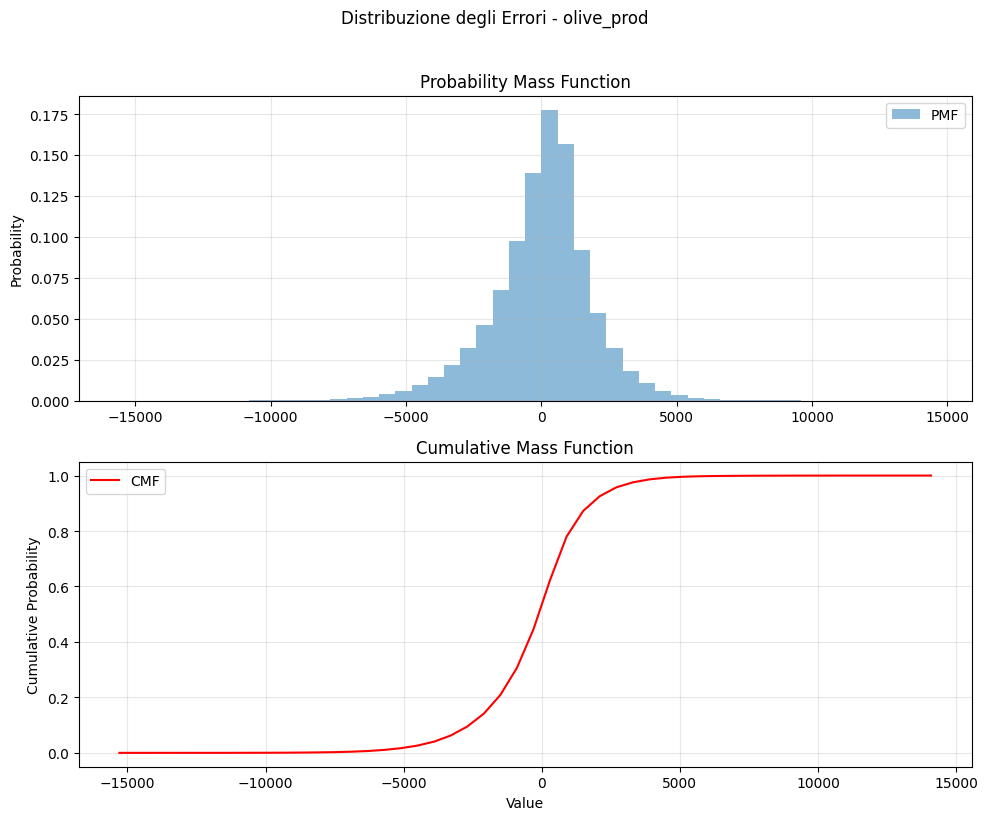


Intervallo di Confidenza 80.0%:
Range: [-2098.98, 2099.65]

Intervallo di Confidenza 85.0%:
Range: [-2698.78, 2099.65]

Intervallo di Confidenza 90.0%:
Range: [-3298.58, 2699.46]

Intervallo di Confidenza 95.0%:
Range: [-4498.19, 3299.26]

Intervallo di Confidenza 99.0%:
Range: [-6297.61, 5098.67]

Analisi per min_oil_prod
--------------------------------------------------

Statistiche degli Errori:
mean: -10.703
variance: 153119.078
std: 391.304
min: -3452.054
max: 3142.031
median: 27.116


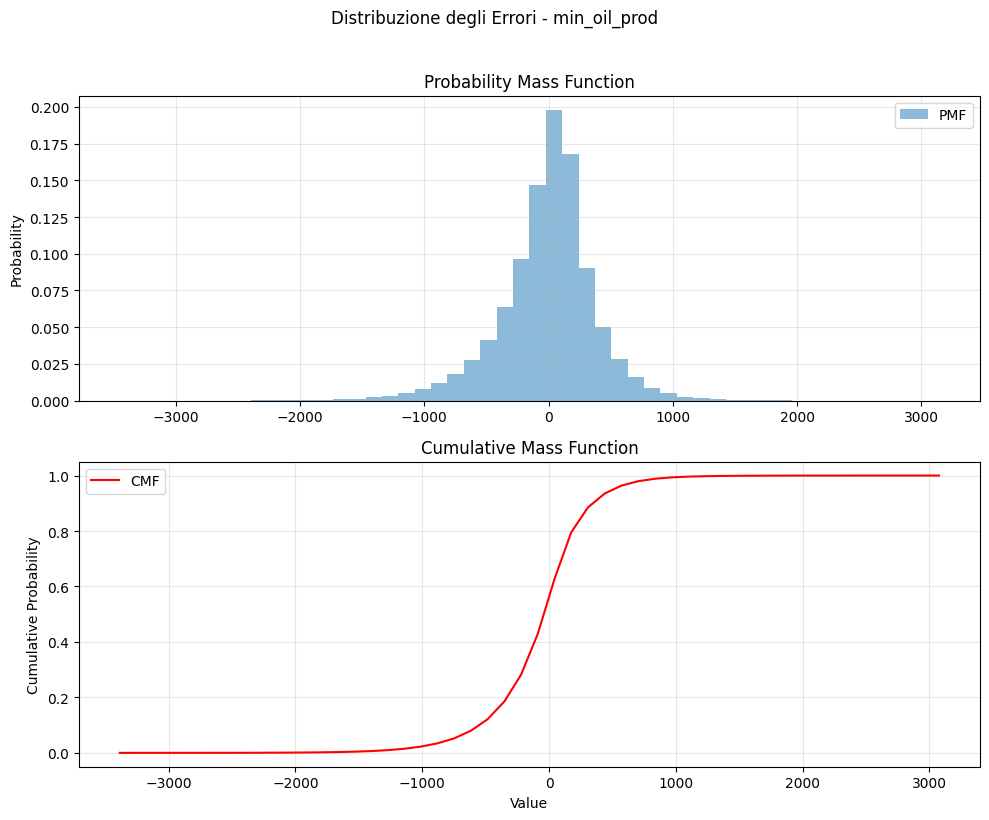


Intervallo di Confidenza 80.0%:
Range: [-484.72, 438.46]

Intervallo di Confidenza 85.0%:
Range: [-616.60, 438.46]

Intervallo di Confidenza 90.0%:
Range: [-748.48, 570.34]

Intervallo di Confidenza 95.0%:
Range: [-880.36, 702.22]

Intervallo di Confidenza 99.0%:
Range: [-1407.89, 1097.86]

Analisi per max_oil_prod
--------------------------------------------------

Statistiche degli Errori:
mean: -3.161
variance: 222900.141
std: 472.123
min: -4621.081
max: 3967.894
median: 42.622


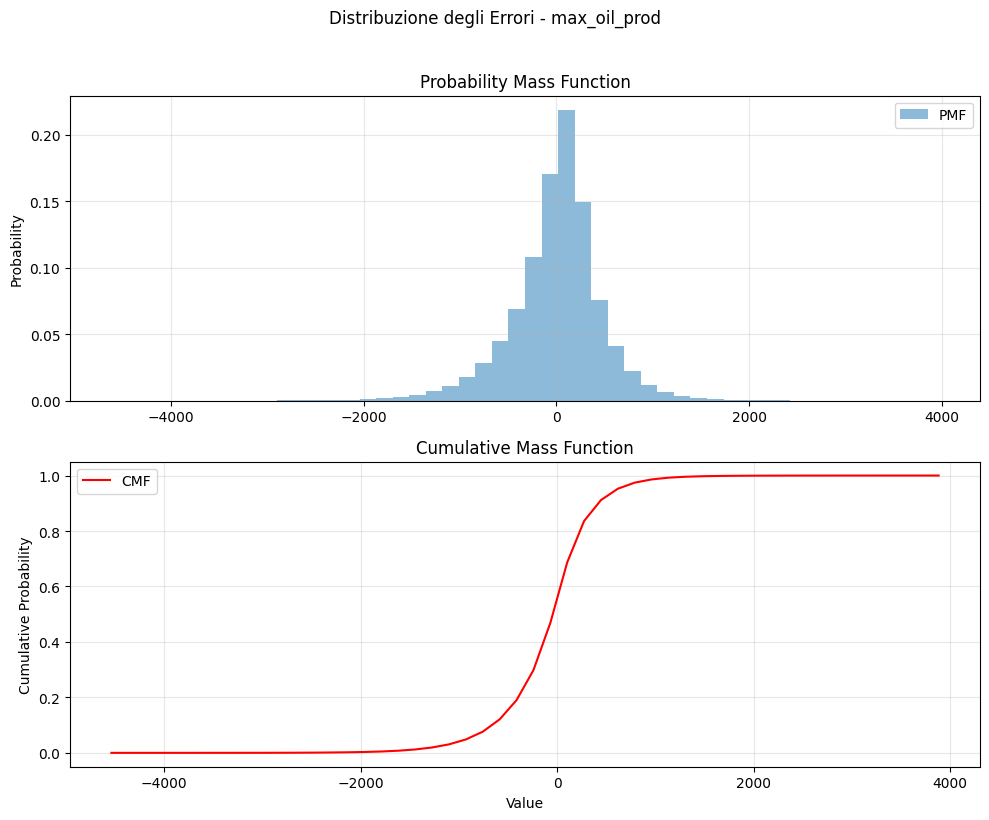


Intervallo di Confidenza 80.0%:
Range: [-584.26, 446.41]

Intervallo di Confidenza 85.0%:
Range: [-756.04, 618.19]

Intervallo di Confidenza 90.0%:
Range: [-756.04, 618.19]

Intervallo di Confidenza 95.0%:
Range: [-1099.60, 961.75]

Intervallo di Confidenza 99.0%:
Range: [-1614.94, 1305.31]

Analisi per avg_oil_prod
--------------------------------------------------

Statistiche degli Errori:
mean: -7.018
variance: 175727.656
std: 419.199
min: -3742.384
max: 3360.436
median: 33.824


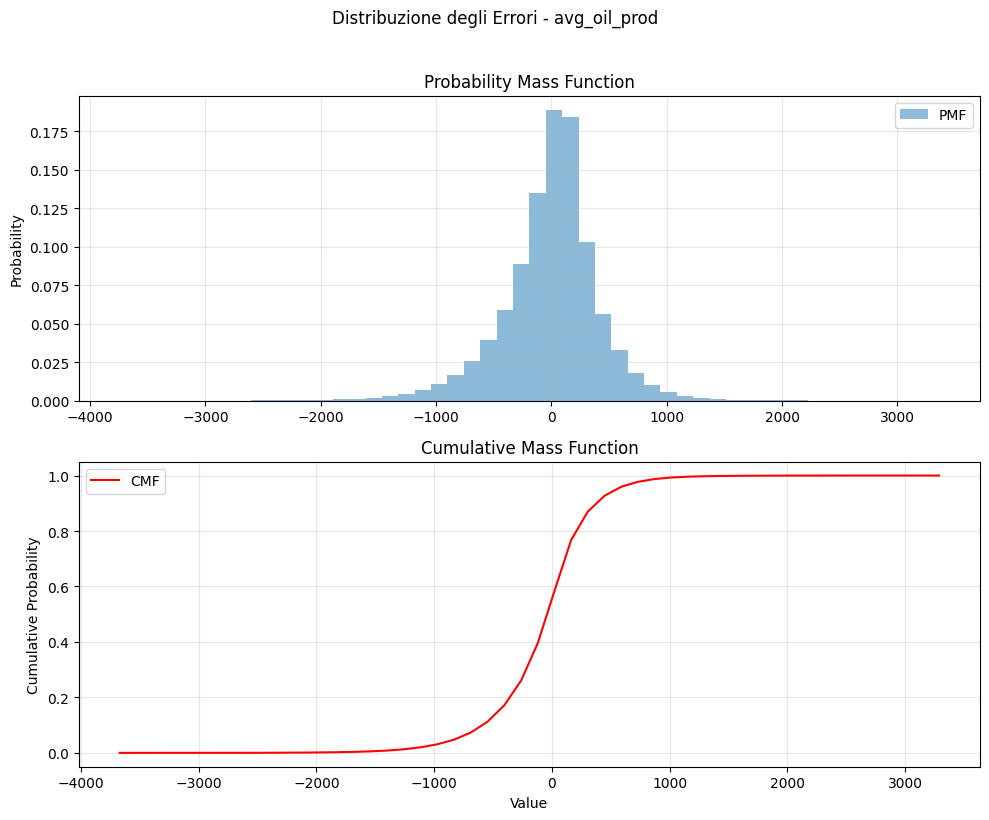


Intervallo di Confidenza 80.0%:
Range: [-546.11, 448.28]

Intervallo di Confidenza 85.0%:
Range: [-546.11, 448.28]

Intervallo di Confidenza 90.0%:
Range: [-688.17, 590.34]

Intervallo di Confidenza 95.0%:
Range: [-972.28, 732.39]

Intervallo di Confidenza 99.0%:
Range: [-1540.51, 1158.56]

Analisi per total_water_need
--------------------------------------------------

Statistiche degli Errori:
mean: 65.956
variance: 3269755.500
std: 1808.246
min: -15266.289
max: 11478.280
median: 354.974


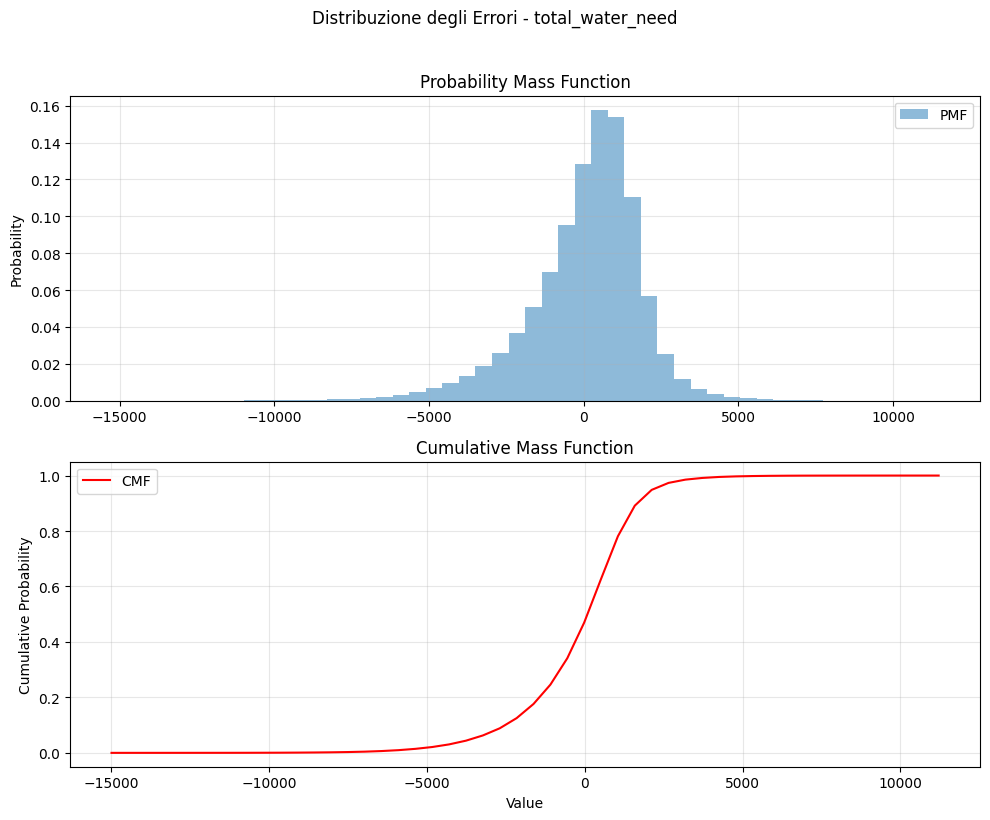


Intervallo di Confidenza 80.0%:
Range: [-2161.45, 2117.68]

Intervallo di Confidenza 85.0%:
Range: [-2696.34, 2117.68]

Intervallo di Confidenza 90.0%:
Range: [-3231.23, 2652.57]

Intervallo di Confidenza 95.0%:
Range: [-4301.02, 3187.46]

Intervallo di Confidenza 99.0%:
Range: [-6440.58, 4792.14]

2. IMPORTANZA DELLE FEATURE
--------------------------------------------------
18750/18750 [==============================] - 184s 10ms/step

Importanza relativa delle feature:
ha: 0.8679
precip_sum: 0.0541
solar_energy_sum: 0.0431
temp_mean: 0.0349

3. ANALISI DISTRIBUZIONALE
--------------------------------------------------
18750/18750 [==============================] - 181s 10ms/step

Analisi distribuzionale per olive_prod

Statistiche Predizioni:
mean: 29887.219
variance: 257054016.000
std: 16032.904
min: 2732.547
max: 87850.508
median: 28077.900

Statistiche Target Reali:
mean: 29870.586
variance: 270589536.000
std: 16449.605
min: 2030.459
max: 99272.031
median: 27900.719


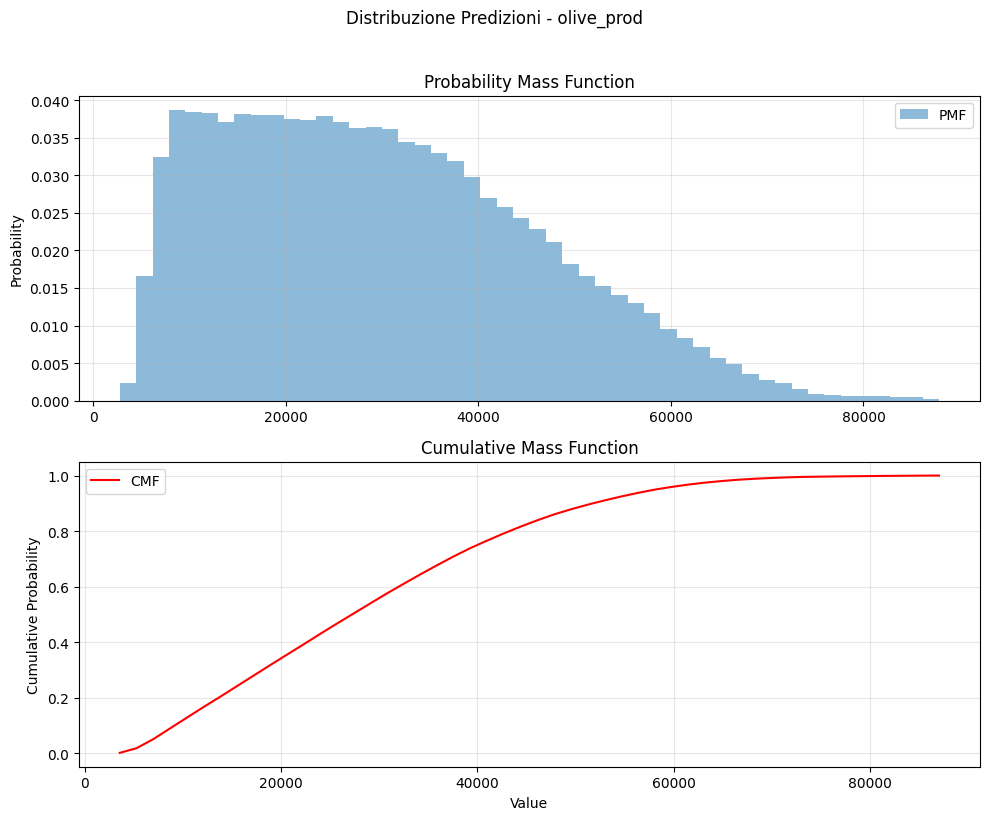

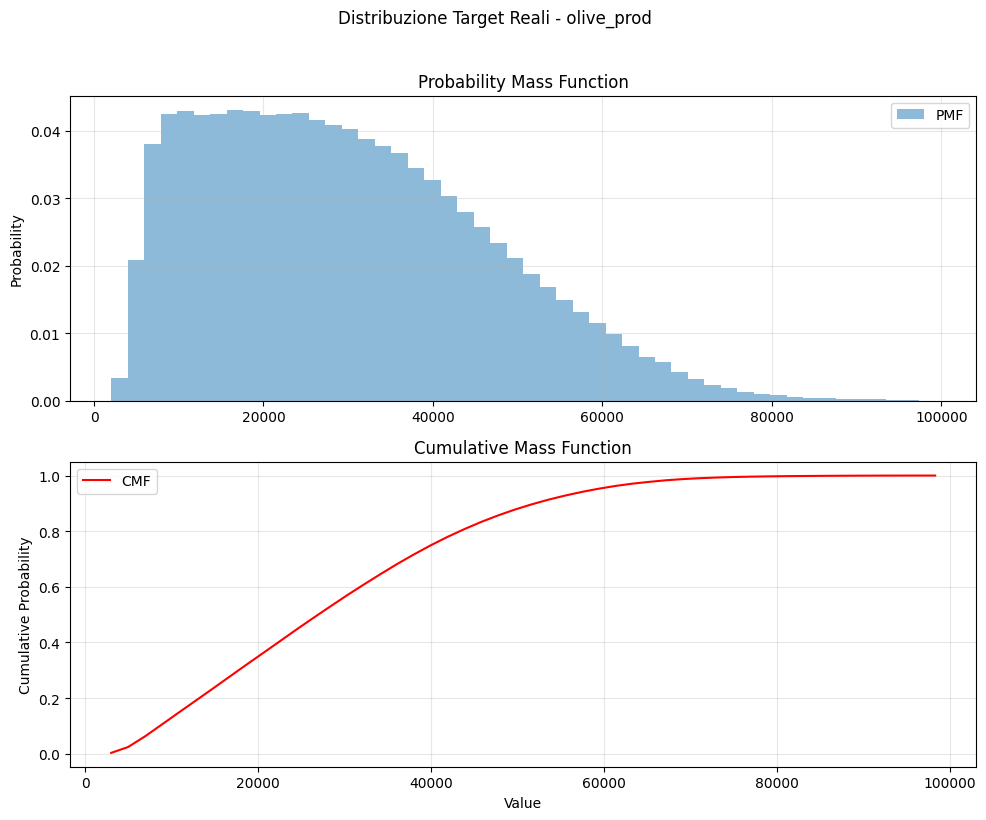


Analisi distribuzionale per min_oil_prod

Statistiche Predizioni:
mean: 5911.217
variance: 11063664.000
std: 3326.208
min: 552.748
max: 19390.480
median: 5451.560

Statistiche Target Reali:
mean: 5921.921
variance: 11676302.000
std: 3417.060
min: 374.026
max: 22359.766
median: 5426.787


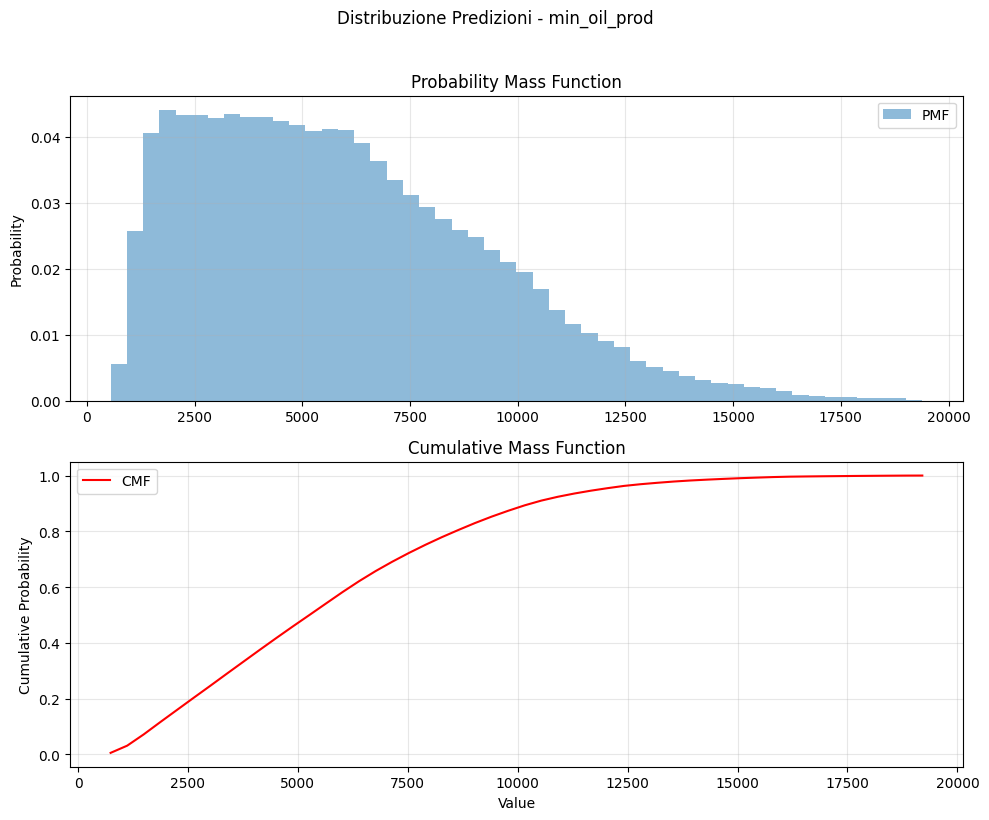

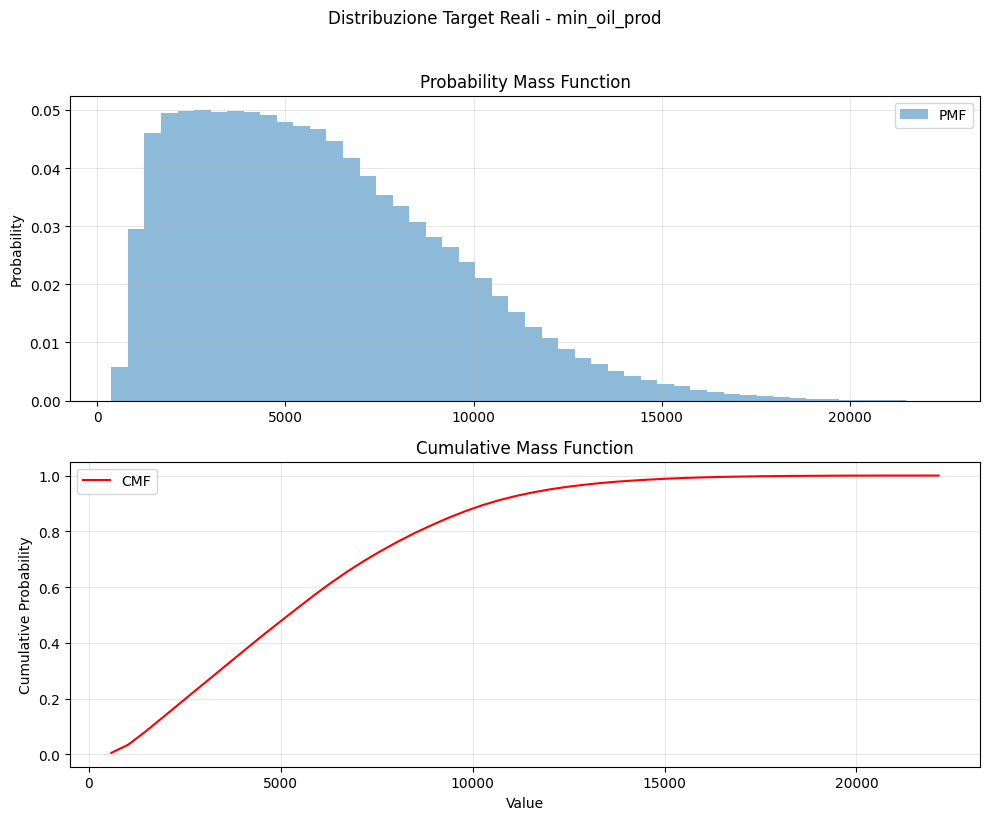


Analisi distribuzionale per max_oil_prod

Statistiche Predizioni:
mean: 7153.816
variance: 16302536.000
std: 4037.640
min: 664.406
max: 24333.047
median: 6596.512

Statistiche Target Reali:
mean: 7156.977
variance: 17168200.000
std: 4143.453
min: 458.719
max: 27636.207
median: 6558.154


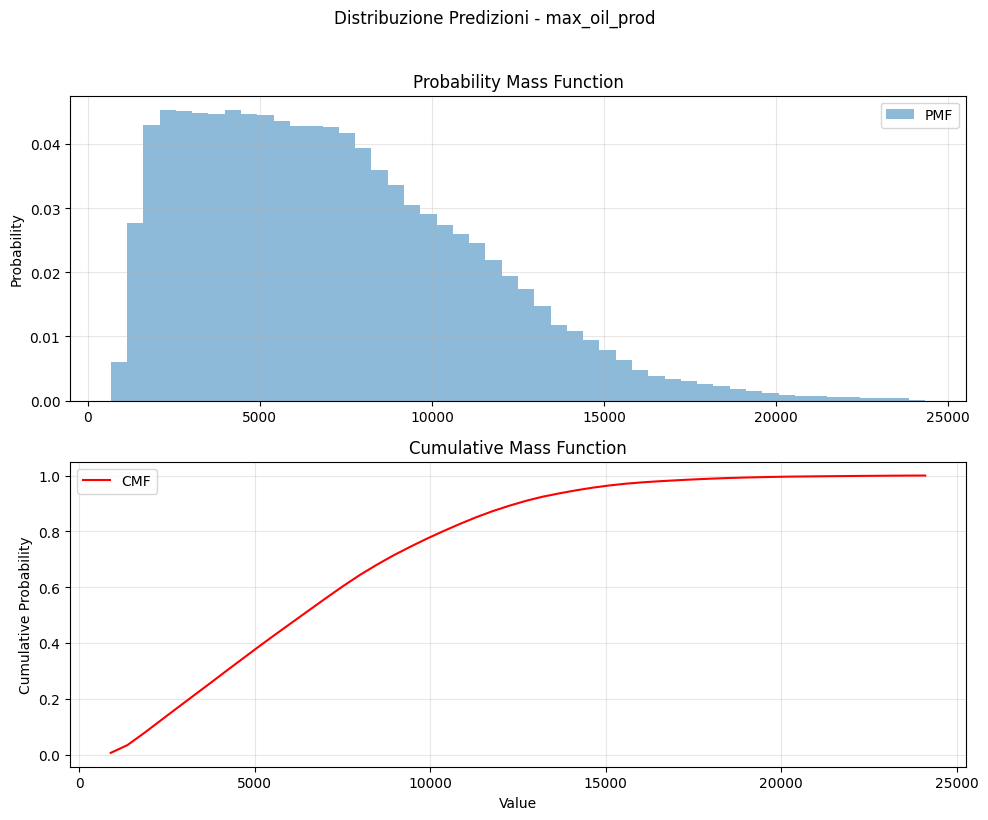

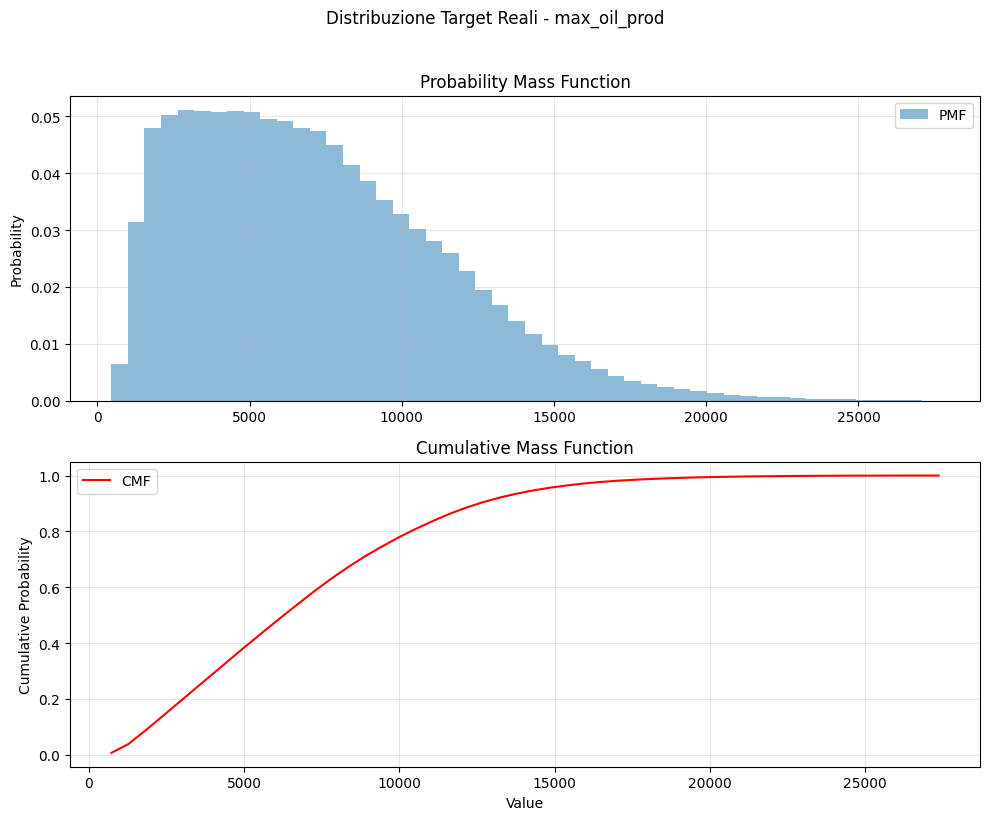


Analisi distribuzionale per avg_oil_prod

Statistiche Predizioni:
mean: 6532.427
variance: 13545224.000
std: 3680.384
min: 608.335
max: 21836.357
median: 6024.207

Statistiche Target Reali:
mean: 6539.446
variance: 14259229.000
std: 3776.139
min: 415.672
max: 24818.859
median: 5996.325


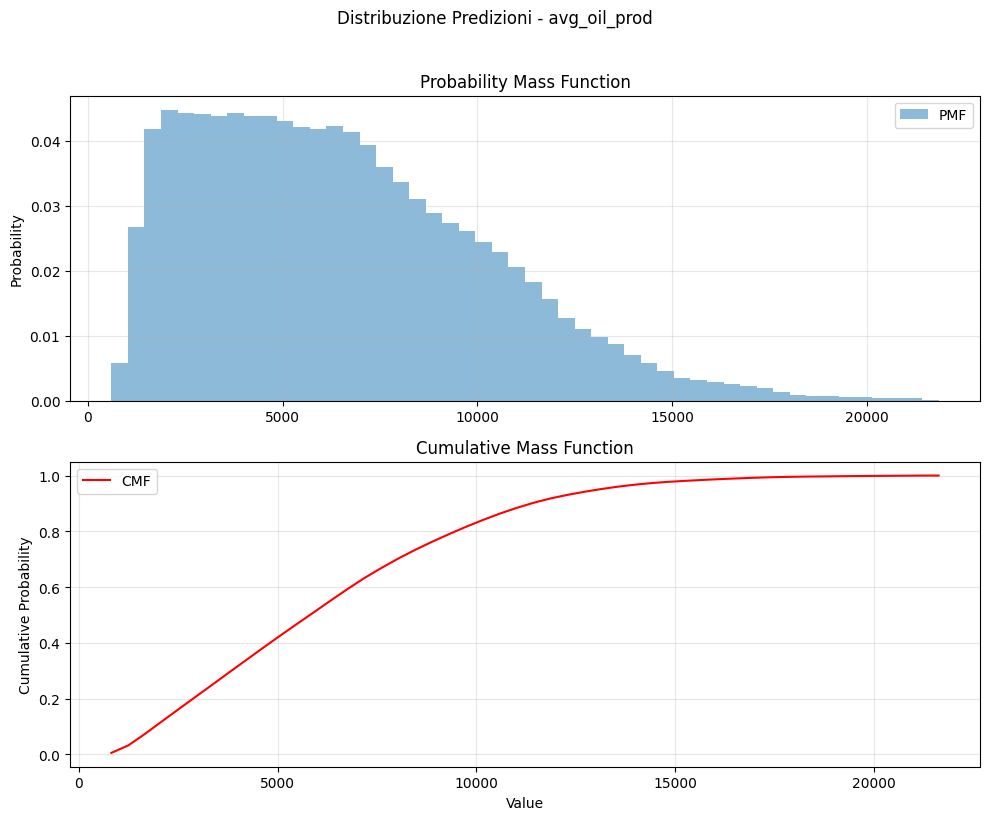

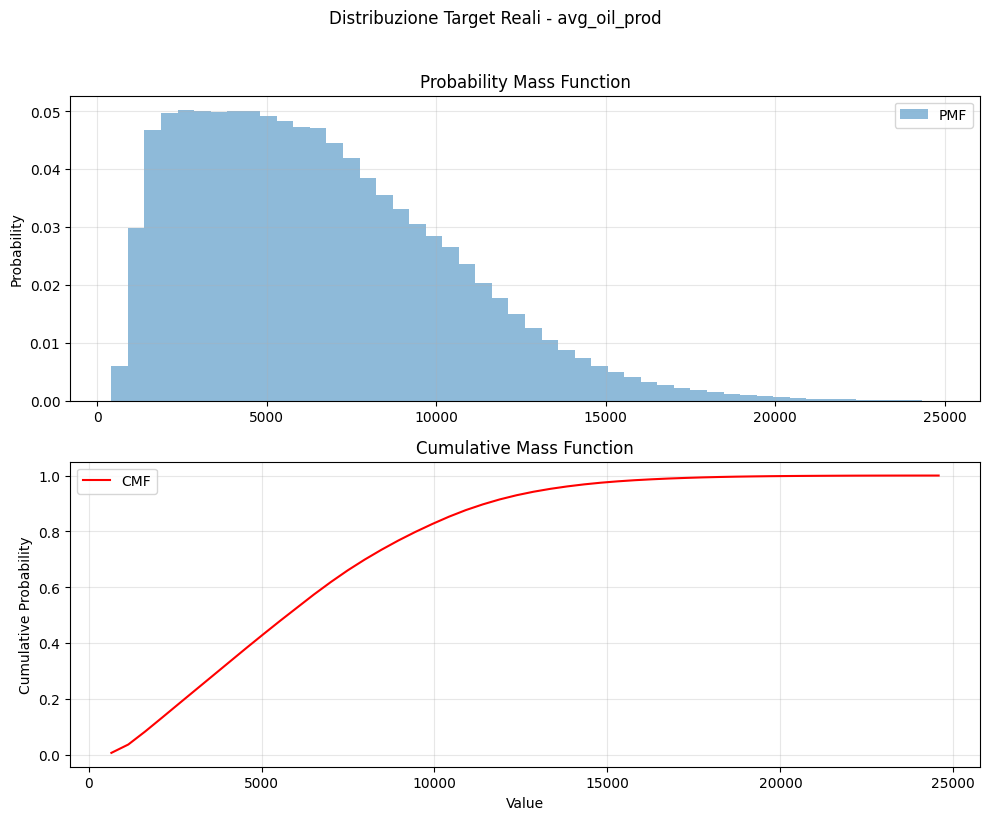


Analisi distribuzionale per total_water_need

Statistiche Predizioni:
mean: 60131.293
variance: 836238848.000
std: 28917.795
min: 10634.454
max: 142663.500
median: 59327.203

Statistiche Target Reali:
mean: 60065.336
variance: 879319232.000
std: 29653.316
min: 8061.355
max: 151159.875
median: 59136.551


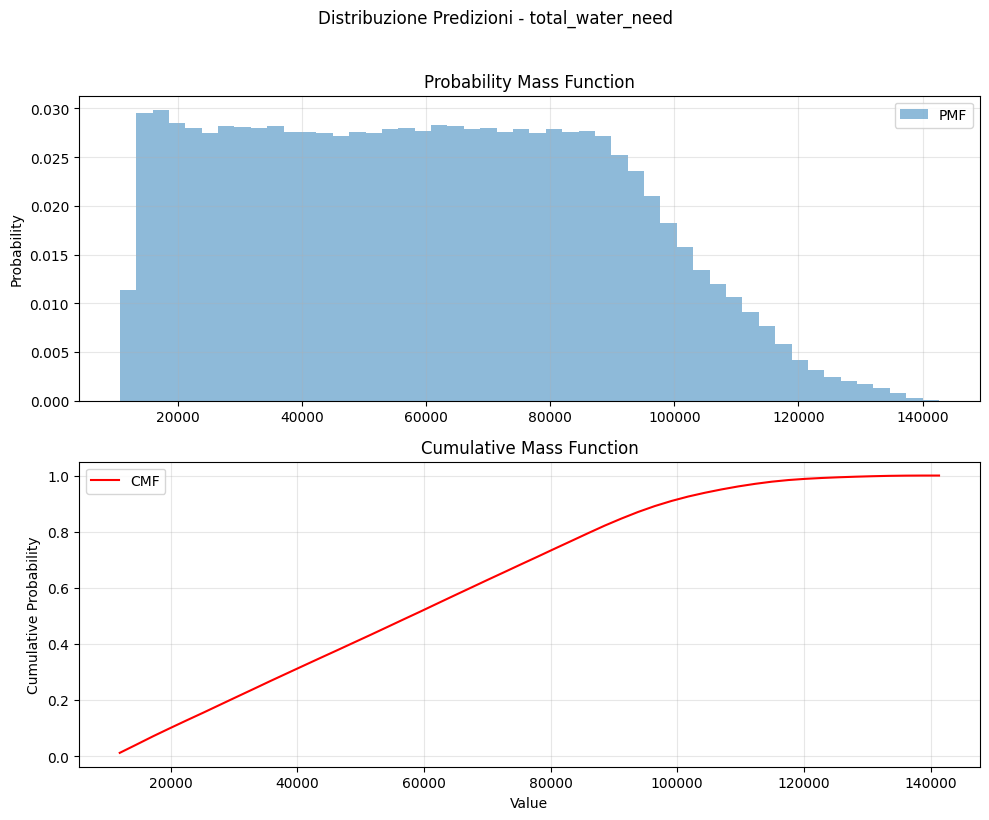

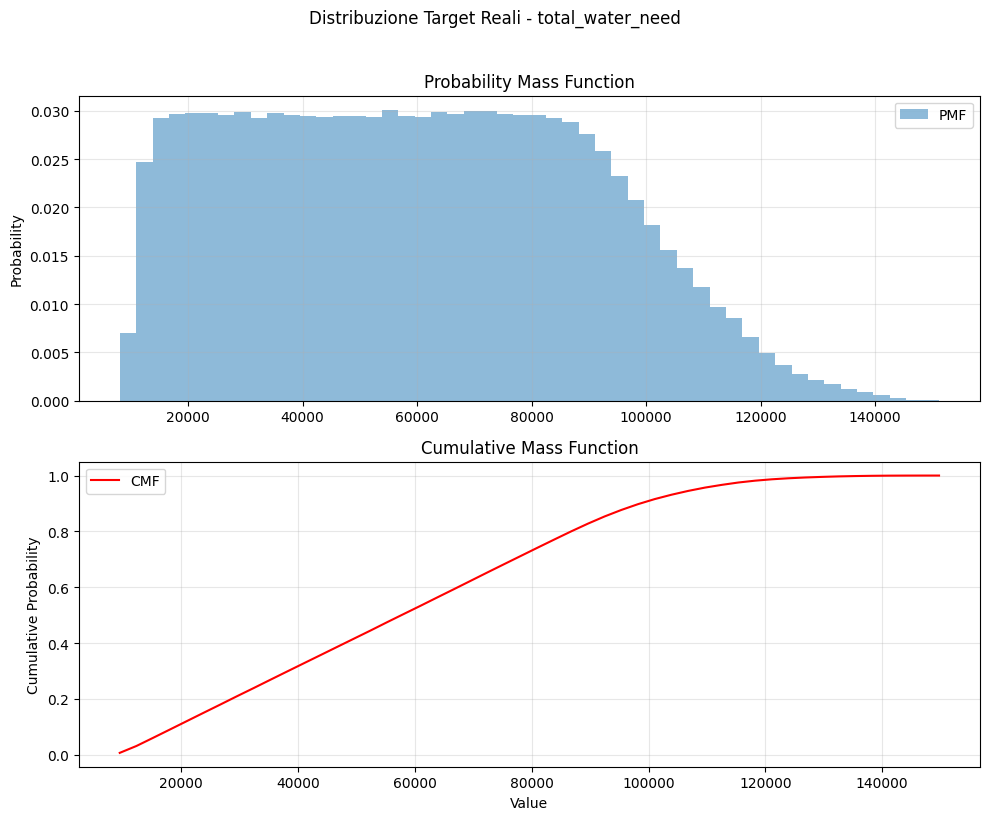

In [22]:
run_comprehensive_analysis(retrained_model, test_data, test_targets, scaler_y)